# Projet RADAR

Ce notebook a pour objectif de documenter et expliciter l'implémentation du projet RADAR, afin de garantir sa reproductibilité. L'exécution des cellules de code permet de réinstaller l'environnement de travail et de comprendre les différentes étapes du pipeline de traitement des données.

## 1. Création de l'environnement de travail

In [1]:
%%writefile pyproject.toml
[build-system]
requires = ["setuptools>=61.0"]
build-backend = "setuptools.build_meta"

[project]
name = "radar-nlp"
version = "0.1.0"
description = "RADAR — Recherche Analytique des Annonces Régionales"
authors = [
    { name = "Rina Razafimahefa" },
    { name = "Mohamed Habib Bah" },
    { name = "Aya Mecheri" },
    { name = "Thibaud Lecomte" }
]
readme = "README.md"
requires-python = ">=3.11"

[tool.setuptools]
package-dir = {"" = "src"}

[tool.setuptools.packages.find]
where = ["src"]

Overwriting pyproject.toml


In [ ]:
%%writefile environment.yml
name: radar
channels:
  - conda-forge
dependencies:
  - python=3.11

### Gestion des dépendances

L'environnement est géré via **Conda**, pour les raisons suivantes :
- présence de bibliothèques scientifiques (`scikit-learn`, `matplotlib`) sensibles aux dépendances binaires,
- meilleure reproductibilité cross-platform (Linuw/MacOS),
- simplicité d'installation.

In [265]:
%%writefile environment.yml
name: radarenv
channels:
  - conda-forge
dependencies:
  - python=3.11
  - pandas
  - numpy
  - requests
  - urllib3
  - beautifulsoup4
  - lxml
  - python-dotenv
  - mistralai
  - scikit-learn
  - matplotlib
  - seaborn
  - duckdb
  - streamlit
  - pyarrow
  - altair
  - ipykernel
  - nltk
  - wordcloud
  - plotly
  - pip
  - pip:
    - -e .
    - streamlit-folium
    - folium

Overwriting environment.yml


### Créer l'environnement Conda

In [ ]:
!conda env create -f environment.yml

### Activer l'environnement Conda depuis le Terminal

```bash
conda activate radarenv
```

## 2. Structure du projet RADAR

### 2.1. Vue d'ensemble de l'architecture

```csharp
radar-nlp/
│
├── src/
│   └── radar/
│       ├── __init__.py
│       │
│       ├── config/
│       │   ├── __init__.py
│       │   ├── queries.yaml        # requêtes métiers (data, IA…)
│       │   └── settings.yaml       # paramètres généraux (paths, options)
│       │
│       ├── scraping/
│       │   ├── __init__.py
│       │   ├── france_travail.py
│       │   ├── hellowork.py
│       │   └── base.py             # logique commune éventuelle
│       │
│       ├── etl/
│       │   ├── __init__.py
│       │   ├── schema.py           # définition schéma DuckDB
│       │   └── pipeline.py         # ingestion / update corpus
│       │
│       ├── nlp/
│       │   ├── __init__.py
│       │   ├── preprocess.py
│       │   ├── features.py
│       │   ├── topics.py
│       │   └── clustering.py
│       │
│       ├── geo/
│       │   ├── __init__.py
│       │   └── enrich.py            # rattachement régions/départements
│       │
│       └── utils/
│           ├── __init__.py
│           └── io.py                # helpers lecture/écriture
│
├── scripts/
│   ├── run_france_travail.py
│   ├── run_hellowork.py
│   ├── run_etl.py
│   └── run_geo_enrichment.py
│
├── app.py
├── pages/                           # pages Streamlit                      
│
├── data/
│   ├── raw/                         # JSON / CSV bruts
│   └── db/                          # radar.duckdb
│
├── doc/
│   ├── notebook/                    # notebook final documenté
│   ├── report/                      # rapport LaTeX
│   └── tutorial/                    # tuto utilisateur / vidéo
│
├── notebooks/                       # notebooks exploratoires
│
├── assets/
│   └── authors.svg
│
├── README.md
├── LICENSE.md
├── environment.yml
└── .gitignore
```

### 2.2. Création des dossiers et fichiers nécessaires

In [ ]:
from pathlib import Path

# ======================================================
# Racine du projet
# ======================================================
ROOT = Path(".").resolve()

# ======================================================
# Dossiers à créer
# ======================================================
directories = [
    # Core package
    "src/radar",
    "src/radar/config",
    "src/radar/scraping",
    "src/radar/etl",
    "src/radar/nlp",
    "src/radar/geo",
    "src/radar/utils",

    # Scripts & app
    "scripts",
    "pages",
    "utils",

    # Data
    "data/raw",
    "data/db",
    "data/processed",

    # Documentation
    "doc",
    "doc/notebook",
    "doc/report",
    "doc/tutorial",

    # Notebooks & assets
    "notebooks",
    "assets",
]

for d in directories:
    path = ROOT / d
    path.mkdir(parents=True, exist_ok=True)

# ======================================================
# Fichiers __init__.py (package Python)
# ======================================================
init_files = [
    "src/radar/__init__.py",
    "src/radar/config/__init__.py",
    "src/radar/scraping/__init__.py",
    "src/radar/etl/__init__.py",
    "src/radar/nlp/__init__.py",
    "src/radar/geo/__init__.py",
    "src/radar/utils/__init__.py",
]

for f in init_files:
    path = ROOT / f
    if not path.exists():
        path.write_text("", encoding="utf-8")

# ======================================================
# 2. Utilitaires I/O (src/radar/utils/io.py)
# ======================================================
io_path = ROOT / "src/radar/utils/io.py"
# Utilisation de r''' pour éviter les erreurs de syntaxe sur les \n
io_content = r'''import json
import pandas as pd
import logging
from pathlib import Path
from typing import Any, Dict, List, Optional

logger = logging.getLogger(__name__)

def save_jsonl(rows: List[Dict[str, Any]], path: Path) -> None:
    if not rows:
        logger.warning(f"Aucune donnée à sauvegarder dans {path}")
        return
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")
    logger.info(f"Sauvegarde réussie : {len(rows)} lignes dans {path}")

def save_csv(rows: List[Dict[str, Any]], path: Path, limit_description: Optional[int] = 4000) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    if not rows:
        pd.DataFrame([]).to_csv(path, index=False, encoding="utf-8")
        return
    df = pd.DataFrame(rows)
    if limit_description and "description" in df.columns:
        df["description"] = df["description"].astype(str).str.slice(0, limit_description)
    df.to_csv(path, index=False, encoding="utf-8")
    logger.info(f"Sauvegarde CSV réussie : {path}")

def load_jsonl(path: Path) -> List[Dict[str, Any]]:
    if not path.exists(): return []
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]
'''
io_path.write_text(io_content.strip(), encoding="utf-8")

# ======================================================
# 3. Normalizer (src/radar/etl/normalizer.py)
# ======================================================
norm_path = ROOT / "src/radar/etl/normalizer.py"
norm_content = r'''import logging
from typing import Any, Dict, List

logger = logging.getLogger(__name__)

def normalize_france_travail(rows: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    out = []
    for r in rows:
        lieu = r.get("lieu", {})
        ent = r.get("entreprise", {})
        out.append({
            "id_offre": f"FT_{r.get('id')}",
            "source": "France Travail",
            "titre": r.get("intitule"),
            "description": r.get("description"),
            "date_publication": r.get("dateCreation"),
            "lieu_nom": lieu.get("libelle"),
            "code_postal": lieu.get("codePostal"),
            "entreprise": ent.get("nom"),
            "type_contrat": r.get("typeContrat"),
            "url": None
        })
    return out

def normalize_emploi_territorial(rows: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    out = []
    for r in rows:
        out.append({
            "id_offre": f"ET_{r.get('job_id')}",
            "source": "Emploi Territorial",
            "titre": r.get("keyword"),
            "description": r.get("content"),
            "date_publication": r.get("scraped_at"),
            "lieu_nom": None,
            "code_postal": r.get("dept"),
            "entreprise": None,
            "type_contrat": None,
            "url": r.get("url")
        })
    return out

def normalize_hellowork(rows: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    out = []
    for r in rows:
        out.append({
            "id_offre": f"HW_{r.get('id')}",
            "source": "HelloWork",
            "titre": r.get("title"),
            "description": r.get("description"),
            "date_publication": r.get("date"),
            "lieu_nom": r.get("city"),
            "code_postal": r.get("cp"),
            "entreprise": r.get("company"),
            "type_contrat": r.get("contract_type"),
            "url": r.get("link")
        })
    return out
'''
norm_path.write_text(norm_content.strip(), encoding="utf-8")

# ======================================================
# 3. Base Scraper (src/radar/scraping/base.py)
# ======================================================
base_path = ROOT / "src/radar/scraping/base.py"
base_content = '''from abc import ABC, abstractmethod
from typing import Any, Dict, List

class BaseScraper(ABC):
    @abstractmethod
    def fetch_all(self, queries: List[str]) -> List[Dict[str, Any]]:
        """Méthode à implémenter pour récupérer les données brutes."""
        pass
'''
base_path.write_text(base_content.strip(), encoding="utf-8")

# ======================================================
# 4. Script d'ingestion principal (scripts/run_ingestion.py)
# ======================================================
run_path = ROOT / "scripts/run_ingestion.py"
run_content = '''import logging
from pathlib import Path
from radar.scraping.france_travail import FranceTravailClient
# Importe ici tes autres clients quand ils seront prêts (ET, etc.)
from radar.etl.normalizer import normalize_france_travail
from radar.utils.io import save_jsonl

# Configurer le logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

def main():
    # 1. Initialisation
    client_ft = FranceTravailClient()
    
    # 2. Définition des recherches (pourrait être chargé depuis config/queries.yaml)
    queries = ["Data Scientist", "Analyste de données", "Intelligence Artificielle"]
    
    # 3. Pipeline France Travail
    logger.info("Début du pipeline France Travail...")
    raw_ft = client_ft.fetch_all(queries)
    
    if raw_ft:
        # On sauvegarde le brut
        save_jsonl(raw_ft, Path("data/raw/france_travail_raw.jsonl"))
        
        # On normalise
        clean_ft = normalize_france_travail(raw_ft)
        
        # On sauvegarde le final (on pourra concaténer avec les autres sources ici)
        save_jsonl(clean_ft, Path("data/processed/offers_merged.jsonl"))
        logger.info(f"Ingestion FT réussie : {len(clean_ft)} offres traitées.")
    else:
        logger.warning("Aucune donnée récupérée pour France Travail.")

if __name__ == "__main__":
    main()
'''
run_path.write_text(run_content.strip(), encoding="utf-8")

# ======================================================
# Fichiers de configuration (placeholders)
# ======================================================
config_files = {
    "src/radar/config/queries.yaml": "# Requêtes métiers (ex: data, IA)\n",
    "src/radar/config/settings.yaml": "# Paramètres globaux du projet\n",
}

for path_str, content in config_files.items():
    path = ROOT / path_str
    if not path.exists():
        path.write_text(content, encoding="utf-8")


# ======================================================
# .gitignore (fichiers à ne pas versionner)
# ======================================================
gitignore_path = ROOT / ".gitignore"

gitignore_content = """
# Environnements & secrets
.env
.env.*
*.env

# Python
__pycache__/
*.py[cod]
.ipynb_checkpoints/

# Conda / venv
.envs/
.venv/
venv/

# Build / packaging
build/
dist/
*.egg-info/

# Logs
*.log

# Data locales / volumineuses
data/db/*.duckdb
data/processed/
data/raw/*.jsonl
data/raw/*.csv
!data/raw/README.md

# OS / IDE
.DS_Store
.vscode/
.idea/
"""

if not gitignore_path.exists():
    gitignore_path.write_text(gitignore_content.strip(), encoding="utf-8")

print("✅ Architecture RADAR initialisée avec succès.")


### 2.3. Affichage de la structure actuelle du projet

In [274]:
import os

def list_files(startpath):
    # Dossiers à ignorer (techniques ou non pertinents pour la doc)
    exclude = {".git", ".ipynb_checkpoints", "__pycache__", ".env"}
    
    print(f"Structure actuelle de : {os.path.basename(os.path.abspath(startpath))}/\n")
    
    for root, dirs, files in os.walk(startpath):
        # Exclusion des dossiers non souhaités
        dirs[:] = [d for d in dirs if d not in exclude]
        
        # Niveau d'indentation
        level = root.replace(startpath, "").count(os.sep)
        indent = " " * 4 * level
        
        # Affichage du dossier courant
        print(f"{indent}├── {os.path.basename(root)}/")
        
        # Affichage des fichiers
        subindent = " " * 4 * (level + 1)
        for f in sorted(files):
            # On ignore les fichiers système ou cachés
            if not f.startswith("."):
                print(f"{subindent}└── {f}")

# Exécution pour la racine du projet
list_files(".")

Structure actuelle de : projet_radar/

├── ./
    └── Dockerfile
    └── LICENSE.md
    └── README.md
    └── app.py
    └── environment.yml
    └── pyproject.toml
    └── radar_notebook.ipynb
    ├── utils/
        └── db.py
        └── design.py
        └── logic.py
    ├── scripts/
        └── init_db.py
        └── init_duckdb_schema.py
        └── merge_et_sources.py
        └── run_emploi_territorial.py
        └── run_emploi_territorial_mistral.py
        └── run_france_travail.py
        └── run_hellowork.py
        └── run_ingestion.py
    ├── doc/
        ├── tutorial/
        ├── report/
        ├── notebook/
    ├── data/
        └── radar_jobs.duckdb
        ├── static/
            └── communes_departement_region.csv
        ├── db/
            └── radar.duckdb
        ├── processed/
            └── emploi_territorial_clean.csv
            └── emploi_territorial_clean.jsonl
            └── emploi_territorial_mistral_clean.jsonl
            └── france_travail_clean.csv
    

## 3. Sources de donnnés et stratégie de collecte

### 3.1. Contexte et objectifs de la collecte

Cette section décrit les sources de données utilisées, les choix méthodologiques associés à leur sélection, ainsi que la stratégie de collecte mise en place pour constituer le corpus d’offres d’emploi analysé dans le projet RADAR.

L’objectif principal de la collecte est de constituer un corpus représentatif et exploitable d’offres d’emploi en France, centré sur les métiers de la data et de l’intelligence artificielle, tout en intégrant une dimension régionale explicite.

### 3.2. Présentation des sources de données

Le corpus est construit à partir de plusieurs sources complémentaires, combinant API officielles et scraping web afin de maximiser la couverture des offres disponibles.

#### 3.2.1. France Travail (API)

- Type de source : API publique
- Nature des données : offres d’emploi structurées
- Avantages :
    - données normalisées
    - informations géographiques fiables
    - accès programmatique
- Contraintes :
    - quotas et pagination
    - champs parfois incomplets ou hétérogènes

##### Présentation générale

France Travail (anciennement Pôle emploi) met à disposition une API publique permettant d’accéder à un ensemble d’offres d’emploi diffusées au niveau national. Cette API constitue une source de données institutionnelle, structurée et particulièrement adaptée à une exploitation automatisée.

Dans le projet RADAR, l’API France Travail est utilisée comme source principale pour la collecte des offres d’emploi liées aux métiers de la data et de l’intelligence artificielle.

##### Nature des données collectées

L’API permet de récupérer des offres d’emploi sous forme structurée, incluant notamment :
- un identifiant d’offre,
- un titre de poste,
- une description textuelle,
- des informations sur l’employeur,
- une localisation (commune, département, région),
- une date de publication,
- des informations contractuelles (type de contrat, salaire lorsque disponible).

Ces champs constituent une base solide pour :
- la constitution d’un corpus textuel exploitable,
- l’analyse NLP,
- l’enrichissement géographique,
- la structuration dans un entrepôt analytique.

##### Modalités d’accès et contraintes techniques

L’accès à l’API se fait via des requêtes HTTP paramétrées par mots-clés (requêtes métiers), avec plusieurs contraintes techniques :
- pagination des résultats,
- limitation du nombre de résultats par requête,
- hétérogénéité des champs selon les offres,
- descriptions parfois absentes ou très courtes.

Afin de gérer ces contraintes, le pipeline de collecte :
- segmente les requêtes en lots,
- agrège les résultats issus de plusieurs requêtes,
- conserve les données brutes avant toute transformation.

##### Avantages de l’API France Travail

L’utilisation de l’API France Travail présente plusieurs avantages majeurs dans le cadre du projet :
- données officielles et fiables,
- format structuré facilitant la normalisation,
- informations géographiques exploitables pour l’analyse régionale,
- stabilité relative de l’API par rapport au scraping HTML.

Ces caractéristiques en font une source particulièrement adaptée à une analyse quantitative et comparative à l’échelle nationale.

##### Limites identifiées

Malgré ses avantages, l’API présente certaines limites :
- couverture partielle du marché de l’emploi (toutes les offres ne transitent pas par France Travail),
- qualité variable des descriptions textuelles,
- informations sur les compétences souvent implicites et non structurées.

Ces limites justifient l’utilisation de sources complémentaires, notamment via le scraping de plateformes privées ou publiques, afin d’enrichir le corpus et d’améliorer la représentativité des analyses.

##### Rôle dans le pipeline RADAR

Dans le pipeline RADAR, l’API France Travail joue le rôle de :
- socle de collecte structuré,
- point d’entrée principal du corpus,
- référence pour la normalisation des champs communs entre sources.

Les données issues de l’API sont stockées dans un format intermédiaire (JSON / CSV), puis intégrées dans l’entrepôt DuckDB après normalisation.

##### 3.2.1.1. Module métier France Travail

La collecte des offres France Travail repose sur un module dédié, chargé exclusivement de l’interaction avec l’API et de la normalisation des données. Les choix de requêtes et les opérations d’écriture sont externalisés afin de respecter une séparation claire des responsabilités.

In [21]:
%%writefile src/radar/scraping/france_travail.py
import os
import time
import logging
import requests
import base64
from pathlib import Path
from dotenv import load_dotenv
from typing import Any, Dict, List
from radar.scraping.base import BaseScraper

logger = logging.getLogger(__name__)

class FranceTravailClient(BaseScraper):
    def __init__(self, env_path: Path = None):
        if env_path is None:
            env_path = Path(__file__).resolve().parent.parent.parent.parent / ".env"
        load_dotenv(dotenv_path=env_path)
        self.client_id = os.getenv("FRANCE_TRAVAIL_CLIENT_ID")
        self.client_secret = os.getenv("FRANCE_TRAVAIL_CLIENT_SECRET")
        self.base_url = "https://api.francetravail.io/partenaire/offresdemploi/v2"

    def get_token(self):
        url = "https://entreprise.francetravail.fr/connexion/oauth2/access_token?realm=/partenaire"
        auth_str = f"{self.client_id}:{self.client_secret}"
        encoded_auth = base64.b64encode(auth_str.encode()).decode()
        
        headers = {
            "Authorization": f"Basic {encoded_auth}",
            "Content-Type": "application/x-www-form-urlencoded"
        }
        
        # On demande explicitement le scope de l'API v2
        payload = {
            "grant_type": "client_credentials",
            "scope": "api_offresdemploiv2"
        }
        
        res = requests.post(url, data=payload, headers=headers)
        
        if res.status_code != 200:
            logger.error(f"Erreur Auth : {res.status_code} - {res.text}")
            res.raise_for_status()
        
        data = res.json()
        # DEBUG : On affiche les droits réels du jeton obtenu
        logger.info(f"Jeton obtenu avec les droits (scope) : {data.get('scope')}")
        
        return data.get("access_token")

    def fetch_all(self, queries: List[str]) -> List[Dict[str, Any]]:
        all_offers = []
        try:
            token = self.get_token()
        except Exception as e:
            logger.error(f"Impossible d'obtenir le token : {e}")
            return []

        headers = {
            "Authorization": f"Bearer {token}",
            "Accept": "application/json"
        }

        for q in queries:
            logger.info(f"Recherche FT : {q}")
            # Paramètres minimaux
            params = {"motsCles": q, "range": "0-49"}
            
            try:
                # Appel à l'API de recherche
                resp = requests.get(f"{self.base_url}/offres/search", params=params, headers=headers)
                
                if resp.status_code == 200:
                    hits = resp.json().get("resultats", [])
                    if hits:
                        all_offers.extend(hits)
                        logger.info(f" -> OK : {len(hits)} offres trouvées")
                elif resp.status_code == 204:
                    logger.info(" -> Aucun résultat (204)")
                elif resp.status_code == 403:
                    logger.error(f" -> [403 Forbidden] Ton jeton n'a pas accès à cette API. Réponse : {resp.text}")
                    # On ne s'arrête pas, on essaie le mot-clé suivant au cas où
                else:
                    logger.warning(f" -> Code {resp.status_code} : {resp.text}")
                
                time.sleep(1.1) # On respecte les 10 appels/sec très largement
            except Exception as e:
                logger.error(f"Erreur technique : {e}")
        
        # Déduplication finale
        unique_offers = {o['id']: o for o in all_offers}.values()
        return list(unique_offers)

Overwriting src/radar/scraping/france_travail.py


##### 3.2.1.2. Script CLI France Travail

La collecte France Travail est pilotée par un script CLI dédié, qui charge dynamiquement les requêtes métiers depuis un fichier de configuration et délègue la logique de collecte au module de scraping.

In [6]:
%%writefile scripts/run_france_travail.py
import logging
import yaml
from pathlib import Path
from radar.scraping.france_travail import FranceTravailClient
from radar.etl.normalizer import normalize_france_travail
from radar.utils.io import save_jsonl, save_csv

# Configuration du logging
logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

def load_keywords():
    """Charge les mots-clés depuis le fichier de configuration central."""
    config_path = Path("src/radar/config/queries.yaml")
    with open(config_path, "r", encoding="utf-8") as f:
        config = yaml.safe_load(f)
    # On utilise 'data_ia' car c'est le nom de la clé dans ton fichier yaml
    return config.get("data_ia", [])

def main():
    # Définition des chemins
    raw_path = Path("data/raw/france_travail_raw.jsonl")
    proc_path = Path("data/processed/france_travail_clean.jsonl")
    
    # 1. Initialisation du client
    logger.info("Initialisation du client France Travail...")
    client = FranceTravailClient()
    
    # 2. Chargement des requêtes depuis le YAML
    queries = load_keywords() # <--- Plus de liste en dur ici !
    logger.info(f"Lancement du scraping pour les requêtes du YAML : {queries}")
    
    # 3. Extraction (Scraping)
    raw_data = client.fetch_all(queries)
    
    if not raw_data:
        logger.error("Aucune donnée n'a pu être récupérée. Vérifiez vos identifiants .env ou le YAML.")
        return

    # 4. Sauvegarde des données brutes
    save_jsonl(raw_data, raw_path)
    
    # 5. Normalisation
    logger.info("Normalisation des données en cours...")
    clean_data = normalize_france_travail(raw_data)
    
    # 6. Sauvegarde des données propres
    save_jsonl(clean_data, proc_path)
    save_csv(clean_data, proc_path.with_suffix(".csv"))
    
    logger.info(f"✅ Terminé : {len(clean_data)} offres normalisées dans {proc_path}")

if __name__ == "__main__":
    main()

Overwriting scripts/run_france_travail.py


#### 3.2.2. HelloWork (Scraping HTML)

- Type de source : scraping web
- Nature des données : pages HTML d’offres d’emploi
- Avantages :
    - volume important d’offres
    - descriptions textuelles riches
- Contraintes :
    - structure HTML variable
    - nécessité de parsing robuste
    - risques liés à l’évolution du site

##### Présentation générale

HelloWork est une plateforme privée de diffusion d’offres d’emploi largement utilisée en France, regroupant des annonces issues de multiples recruteurs et cabinets.

Contrairement à France Travail, HelloWork ne fournit pas d’API publique pour l’accès programmatique aux offres. L’accès aux données repose donc sur une approche de scraping web des pages HTML.

Dans le projet RADAR, HelloWork est utilisée comme source complémentaire afin d’enrichir le corpus d’offres, notamment en termes de volume et de richesse des descriptions textuelles.

##### Nature des données collectées

Le scraping permet de récupérer, à partir des pages d’offres :
- le titre du poste,
- le nom de l’entreprise,
- la localisation,
- la description complète de l’offre,
- la date de publication (lorsqu’elle est disponible),
- l’URL de l’annonce.

Ces informations, bien que moins structurées que celles issues d’une API, restent intéressantes pour les analyses NLP, en raison de la richesse lexicale des descriptions.

##### Contraintes techniques et méthodologiques

Le scraping HTML présente plusieurs contraintes spécifiques :
- structure des pages susceptible d’évoluer,
- données non normalisées,
- nécessité de parser le contenu HTML de manière robuste,
- absence de garanties sur l’exhaustivité ou la stabilité des champs.

Afin de limiter ces risques, le pipeline de scraping HelloWork :
- isole les sélecteurs HTML dans un module dédié,
- applique une normalisation minimale commune aux autres sources,
- conserve les données brutes avant toute transformation.

##### Rôle dans le pipeline RADAR

HelloWork joue un rôle complémentaire dans le pipeline RADAR :
- enrichissement du corpus textuel,
- amélioration de la représentativité des offres privées,
- apport de descriptions longues favorables aux analyses NLP.

Les données collectées sont intégrées au même schéma logique que celles issues de l’API France Travail, ce qui permet une exploitation conjointe dans l’entrepôt analytique.

##### 3.2.2.1. Module métier HelloWork

Le scraping HelloWork repose sur un module dédié chargé d’extraire les informations essentielles depuis les pages HTML des offres.

Contrairement à l’API France Travail, cette source nécessite une approche plus flexible, en raison de la variabilité de la structure des pages.

Les données collectées sont volontairement normalisées selon un schéma commun minimal, afin de permettre leur intégration conjointe dans l’entrepôt analytique DuckDB.

In [30]:
%%writefile src/radar/scraping/hellowork.py
import time
import logging
import requests
from bs4 import BeautifulSoup
from typing import Any, Dict, List
from radar.scraping.base import BaseScraper

logger = logging.getLogger(__name__)

class HelloWorkClient(BaseScraper):
    def __init__(self):
        self.base_url = "https://www.hellowork.com"
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
        }

    def fetch_all(self, queries: List[str], max_pages: int = 3) -> List[Dict[str, Any]]:
        all_offers = []
        
        for q in queries:
            slug = q.lower().replace(" ", "-")
            logger.info(f"Recherche HelloWork : {q}")
            
            links_for_query = []
            
            for page in range(1, max_pages + 1):
                # Construction de l'URL avec pagination (?p=2, ?p=3...)
                url = f"{self.base_url}/fr-fr/emploi/metier_{slug}.html?p={page}"
                
                try:
                    logger.info(f"  -> Scraping page {page}...")
                    res = requests.get(url, headers=self.headers, timeout=10)
                    if res.status_code != 200:
                        break # Si la page n'existe pas, on passe au mot-clé suivant
                    
                    soup = BeautifulSoup(res.text, "html.parser")
                    
                    # Extraction des liens d'offres
                    page_links = []
                    for a in soup.find_all('a', href=True):
                        href = a['href']
                        if "/emplois/" in href and href.endswith(".html"):
                            full_url = self.base_url + href if href.startswith("/") else href
                            page_links.append(full_url)
                    
                    if not page_links:
                        break # Plus de résultats trouvés
                        
                    links_for_query.extend(page_links)
                    time.sleep(1) # Pause entre les pages de liste
                    
                except Exception as e:
                    logger.error(f"Erreur sur {q} page {page}: {e}")
                    break

            # Nettoyage des doublons pour ce mot-clé
            links_for_query = list(set(links_for_query))
            logger.info(f"  -> Total : {len(links_for_query)} liens trouvés pour '{q}'")

            # Extraction du contenu de chaque offre
            for link in links_for_query:
                offer = self._parse_offer(link)
                if offer:
                    all_offers.append(offer)
                time.sleep(0.4) # Pause entre chaque offre
                    
        return all_offers

    def _parse_offer(self, url: str) -> Dict[str, Any]:
        try:
            res = requests.get(url, headers=self.headers, timeout=10)
            if res.status_code != 200:
                return None
                
            soup = BeautifulSoup(res.text, "html.parser")
            
            # Extraction plus précise des champs
            title = soup.find("h1")
            company = soup.select_one("span[class*='company']") or soup.select_one("span[data-cy='companyName']")
            city = soup.select_one("span[class*='location']") or soup.select_one("span[data-cy='locationName']")
            
            return {
                "id": url.split("/")[-1].replace(".html", ""),
                "title": title.get_text(strip=True) if title else "Sans titre",
                "company": company.get_text(strip=True) if company else "Entreprise inconnue",
                "city": city.get_text(strip=True) if city else "France",
                "description": soup.get_text(separator=" ", strip=True)[500:3000],
                "link": url,
                "date": None
            }
        except:
            return None

Overwriting src/radar/scraping/hellowork.py


##### 3.2.2.2. Script CLI Hellowork

In [8]:
%%writefile scripts/run_hellowork.py
import logging
import yaml
from pathlib import Path
from radar.scraping.hellowork import HelloWorkClient
from radar.etl.normalizer import normalize_hellowork
from radar.utils.io import save_jsonl, save_csv

# Configuration du logging
logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

def load_keywords():
    """Charge les mots-clés métiers depuis queries.yaml."""
    config_path = Path("src/radar/config/queries.yaml")
    with open(config_path, "r", encoding="utf-8") as f:
        config = yaml.safe_load(f)
    # On cible 'data_ia' car c'est le nom dans ton fichier
    return config.get("data_ia", [])

def main():
    # 1. Configuration des chemins
    raw_path = Path("data/raw/hellowork_raw.jsonl")
    proc_path = Path("data/processed/hellowork_clean.jsonl")

    # 2. Chargement des mots-clés via la config centralisée
    keywords = load_keywords()
    
    if not keywords:
        logger.error("Aucun mot-clé trouvé dans queries.yaml (clé 'data_ia')")
        return

    # 3. Initialisation du client
    client = HelloWorkClient()
    
    logger.info(f"Lancement du scraping HelloWork pour : {keywords}")
    
    # 4. Extraction
    raw_data = client.fetch_all(keywords)
    
    if not raw_data:
        logger.warning("Aucune donnée récupérée pour HelloWork.")
        return

    # 5. Sauvegarde du brut
    save_jsonl(raw_data, raw_path)
    
    # 6. Normalisation
    logger.info("Normalisation des données HelloWork...")
    clean_data = normalize_hellowork(raw_data)
    
    # 7. Sauvegarde des données propres
    save_jsonl(clean_data, proc_path)
    save_csv(clean_data, proc_path.with_suffix(".csv"))
    
    logger.info(f"✅ Terminé : {len(clean_data)} offres HelloWork traitées et normalisées.")

if __name__ == "__main__":
    main()

Overwriting scripts/run_hellowork.py


#### 3.2.3. Emploi Territorial (scraping)

- Type de source : Cette source est traitée via deux approches complémentaires pour maximiser la couverture
- Nature des données : pages HTML d’offres d’emploi
- Avantages :
    - focus sur les offres publiques territoriales
- Contraintes :
    - faible volume d’offres
    - annonces sujettes à péremption rapide
    - dénomination des métiers non standardisée

##### Présentation générale

Emploi Territorial est la plateforme de référence pour la diffusion des offres d’emploi de la fonction publique territoriale en France. Elle regroupe des annonces publiées par les collectivités locales (communes, départements, régions, établissements publics).

À l’instar de HelloWork, Emploi Territorial ne propose pas d’API publique. L’accès aux données repose donc sur une double approche de scraping web et une approche utilisant un Agent IA.

Dans le projet RADAR, cette source permet :
d’intégrer le secteur public territorial,
- d’analyser la place des métiers de la data et de l’IA dans les collectivités,
- de comparer les dynamiques public / privé à l’échelle régionale.

##### Nature des données collectées

Le scraping Emploi Territorial permet de récupérer :
- l’URL de l’offre,
- un identifiant d’offre,
- le département de publication,
- le mot-clé de recherche,
- le contenu textuel complet de l’annonce.

Les descriptions sont généralement longues et détaillées, ce qui constitue un atout majeur pour les analyses NLP.

##### Contraintes techniques spécifiques

Le scraping web Emploi Territorial présente plusieurs particularités :
- nécessité d’une session persistante (cookies),
- navigation en plusieurs étapes (liste → fiche offre),
- structure HTML variable selon les pages,
- protection légère contre les requêtes automatisées.

Ces contraintes ont conduit à :
- l’utilisation d’une session requests.Session,
- l’ajout de délais aléatoires entre les requêtes,
- une extraction volontairement large du contenu textuel afin d’assurer la robustesse.

Enfin, compte tenu de la double approche de collecte (scraping + Agent IA), une attention particulière est portée à la déduplication des offres avant intégration dans le corpus final.

##### Rôle dans le pipeline RADAR

Les données issues d’Emploi Territorial jouent un rôle complémentaire :
- enrichissement du corpus textuel,
- couverture du secteur public,
- comparaison inter-sectorielle.

Comme pour les autres sources, les données sont normalisées selon un schéma commun minimal avant leur intégration dans l’entrepôt DuckDB.

##### 3.2.3.1. Scraping HTML (approche standard)

1. Module métier Emploi Territorial

In [ ]:
%%writefile scripts/run_emploi_territorial_mistral.py
import yaml
import logging
import requests
from bs4 import BeautifulSoup
import time
from pathlib import Path
from radar.utils.io import save_jsonl

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def main():
    with open("src/radar/config/queries.yaml", "r", encoding="utf-8") as f:
        config = yaml.safe_load(f)
    
    # Récupération dynamique des mots-clés
    keywords = config.get("data_ia", [])
    search_query = " ou ".join(keywords)
    
    # Accès aux paramètres imbriqués dans 'sources'
    et_cfg = config.get("sources", {}).get("emploi_territorial", {})
    familles = et_cfg.get("et_famille_metiers", "A7,A1")
    max_pages = et_cfg.get("max_pages", 25)
    
    base_url = "https://www.emploi-territorial.fr/emploi-mobilite/"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"}
    
    offers = []
    for page in range(1, max_pages + 1):
        url = f"{base_url}?adv-search={search_query}&search-fam-metier={familles}&page={page}"
        logger.info(f"Agent IA : Scraping page {page}/{max_pages} (Familles: {familles})")
        
        try:
            r = requests.get(url, headers=headers, timeout=15)
            if r.status_code != 200: break
            
            soup = BeautifulSoup(r.text, "html.parser")
            rows = soup.select("tr[id^='O']")
            if not rows: break
                
            for row in rows:
                link = row.select_one("a.lien-details-offre")
                if not link: continue
                
                offer_url = "https://www.emploi-territorial.fr" + link["href"]
                
                # Scraping profond du contenu
                detail_r = requests.get(offer_url, headers=headers, timeout=10)
                detail_soup = BeautifulSoup(detail_r.text, "html.parser")
                main_div = detail_soup.select_one("div#contenuOffre, div.contenu-offre, main")
                
                description = ""
                if main_div:
                    for tag in main_div(["script", "style"]): tag.decompose()
                    description = main_div.get_text(separator=" ", strip=True)
                
                offers.append({
                    "titre": link.get_text(strip=True),
                    "url": offer_url,
                    "description": description,
                    "source": "Emploi Territorial (Mistral Method)"
                })
                time.sleep(0.2)
        except Exception as e:
            logger.error(f"Erreur page {page} : {e}")
            break

    if offers:
        output_raw = Path("data/raw/emploi_territorial_mistral_raw.jsonl")
        save_jsonl(offers, output_raw)
        logger.info(f"✅ Mistral Method : {len(offers)} offres récupérées.")

if __name__ == "__main__":
    main()

Overwriting src/radar/scraping/emploi_territorial.py


2. Script CLI Emploi Territorial

In [49]:
%%writefile scripts/run_emploi_territorial.py
import yaml
import logging
from pathlib import Path
from radar.scraping.emploi_territorial import EmploiTerritorialClient
from radar.etl.normalizer import normalize_emploi_territorial
from radar.utils.io import save_jsonl, save_csv

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def main():
    with open("src/radar/config/queries.yaml", "r", encoding="utf-8") as f:
        config = yaml.safe_load(f)
    
    keywords = config.get("data_ia", [])
    scrap_cfg = config.get("scraping", {})
    
    max_p = scrap_cfg.get("max_pages_emploi_territorial", 50)
    familles = scrap_cfg.get("et_famille_metiers", "A7,A1")

    client = EmploiTerritorialClient()
    logger.info(f"Démarrage ET | Pages: {max_p} | Familles: {familles}")
    
    raw_data = client.fetch_all(queries=keywords, familles=familles, max_pages=max_p)
    
    if raw_data:
        save_jsonl(raw_data, Path("data/raw/emploi_territorial_raw.jsonl"))
        clean_data = normalize_emploi_territorial(raw_data)
        save_jsonl(clean_data, Path("data/processed/emploi_territorial_clean.jsonl"))
        save_csv(clean_data, Path("data/processed/emploi_territorial_clean.csv"))
        logger.info(f"✅ ET : {len(clean_data)} offres.")

if __name__ == "__main__":
    main()

Overwriting scripts/run_emploi_territorial.py


#### 3.2.3.2. Scraping à l'aide d'un agent IA (approche alternative)

1. Script de scraping avec Agent IA

In [10]:
%%writefile scripts/run_emploi_territorial_mistral.py
import yaml
import logging
import requests
from bs4 import BeautifulSoup
import time
from pathlib import Path
from radar.utils.io import save_jsonl

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def main():
    # 1. Chargement de la config
    with open("src/radar/config/queries.yaml", "r", encoding="utf-8") as f:
        config = yaml.safe_load(f)
    
    keywords = config.get("data_ia", [])
    search_query = " ou ".join(keywords)
    
    et_cfg = config.get("sources", {}).get("emploi_territorial", {})
    familles = et_cfg.get("et_famille_metiers", "A7,A1")
    max_pages = et_cfg.get("max_pages", 20000)
    
    base_url = "https://www.emploi-territorial.fr/emploi-mobilite/"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"}
    
    offers = []
    for page in range(1, max_pages + 1):
        url = f"{base_url}?adv-search={search_query}&search-fam-metier={familles}&page={page}"
        logger.info(f"Agent IA : Scraping page {page}/{max_pages}")
        
        try:
            r = requests.get(url, headers=headers, timeout=15)
            if r.status_code != 200: 
                logger.warning(f"Sortie : Status {r.status_code}")
                break
            
            soup = BeautifulSoup(r.text, "html.parser")
            rows = soup.select("tr[id^='O']")
            
            # Condition de sortie si la page est vide (Break)
            if not rows: 
                logger.info("Plus aucun résultat trouvé. Arrêt du scraping.")
                break
                
            for row in rows:
                link = row.select_one("a.lien-details-offre")
                if not link: continue
                
                offer_url = "https://www.emploi-territorial.fr" + link["href"]
                
                # Scraping du détail
                detail_r = requests.get(offer_url, headers=headers, timeout=10)
                detail_soup = BeautifulSoup(detail_r.text, "html.parser")
                main_div = detail_soup.select_one("div#contenuOffre, div.contenu-offre, main")
                
                description = ""
                if main_div:
                    for tag in main_div(["script", "style"]): tag.decompose()
                    description = main_div.get_text(separator=" ", strip=True)
                
                offers.append({
                    "titre": link.get_text(strip=True),
                    "url": offer_url,
                    "description": description,
                    "source": "Emploi Territorial (Mistral)"
                })
                time.sleep(0.2)
                
        except Exception as e:
            logger.error(f"Erreur fatale : {e}")
            break

    if offers:
        output_raw = Path("data/raw/emploi_territorial_mistral_raw.jsonl")
        save_jsonl(offers, output_raw)
        logger.info(f"✅ Terminé : {len(offers)} offres collectées.")

if __name__ == "__main__":
    main()

Overwriting scripts/run_emploi_territorial_mistral.py


2. Gestion des doublons et merge des données Emploi Territorial

In [24]:
%%writefile scripts/merge_et_sources.py
import pandas as pd
from pathlib import Path
import logging
import json

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def merge_sources():
    std_path = Path("data/processed/emploi_territorial_clean.jsonl")
    mistral_raw_path = Path("data/raw/emploi_territorial_mistral_raw.jsonl")
    output_path = Path("data/processed/emploi_territorial_mistral_clean.jsonl")

    if not std_path.exists() or not mistral_raw_path.exists():
        logger.error("Fichiers sources manquants.")
        return

    # 1. Charger les URLs existantes pour dédupliquer
    existing_urls = set()
    with open(std_path, 'r', encoding='utf-8') as f:
        for line in f:
            try: existing_urls.add(json.loads(line)['url'])
            except: continue

    # 2. Charger Mistral
    mistral_data = []
    with open(mistral_raw_path, 'r', encoding='utf-8') as f:
        for line in f:
            try: mistral_data.append(json.loads(line))
            except: continue
    
    # 3. Filtrage et Alignement (Normalisation)
    final_mistral = []
    for o in mistral_data:
        if o['url'] not in existing_urls:
            # On aligne EXACTEMENT sur les colonnes du Standard
            final_mistral.append({
                "id_offre": o['url'].rstrip('/').split('/')[-1], # On extrait l'ID de l'URL
                "source": "Emploi Territorial (Mistral)",
                "titre": o['titre'],
                "description": o['description'], # Aligné sur 'Standard'
                "date_publication": None,        # Information non disponible
                "lieu_nom": "Inconnu",           # Aligné sur 'Standard'
                "code_postal": None,
                "entreprise": "Collectivité Territoriale",
                "type_contrat": "Non précisé",
                "url": o['url']
            })
            # On ajoute l'URL au set pour éviter les doublons internes à Mistral
            existing_urls.add(o['url'])

    # 4. Sauvegarde
    with open(output_path, 'w', encoding='utf-8') as f:
        for entry in final_mistral:
            f.write(json.dumps(entry, ensure_ascii=False) + '\n')
            
    logger.info(f"✅ Normalisation terminée : {len(final_mistral)} nouvelles offres au format standard.")

if __name__ == "__main__":
    merge_sources()

Overwriting scripts/merge_et_sources.py


### 3.3. Stratégie de requêtage et périmètre métier

#### 3.3.1. Définition du périmètre métier

Le projet se concentre sur les métiers liés à =
- la data science,
- l'analyse de données,
- l'ingénierie data,
- le machine learning,
- le NLP et les technologies associées.

Ce périmètre a été défini afin de :
- limiter le bruit dans le corpus,
- garantir la cohérence des analyses NLP,
- permettre des comparaisons pertinentes entre régions.

#### 3.3.2. Paramétrisation des requêtes

##### Principe général

Dans le projet RADAR, les requêtes utilisées pour interroger les différentes sources de données ne sont pas codées en dur dans les scripts. Elles sont externalisées dans un fichier de configuration dédié, afin de séparer clairement :
- la logique métier (scraping, API, normalisation),
- la stratégie de requêtage (mots-clés, périmètre, zones géographiques).

Ce choix permet d’améliorer la maintenabilité, la réutilisabilité et la lisibilité du pipeline de collecte.

##### Motivations

La paramétrisation des requêtes répond à plusieurs objectifs méthodologiques :

1. Faciliter l’évolution du périmètre d’étude
   - ajout ou suppression de mots-clés métiers,
   - adaptation à de nouveaux domaines (ex. cybersécurité, data engineering avancé).

2. Éviter la duplication de logique
    - une même liste de requêtes peut être utilisée par plusieurs sources (API, scraping).

3. Améliorer la reproductibilité
    - le périmètre de collecte est explicitement documenté,
    - une exécution peut être reproduite à l’identique à partir du fichier de configuration.

4. Renforcer la clarté du code
    - les scripts se concentrent sur *comment collecter*,
    - la configuration décrit *quoi collecter*.

##### Organisation de la configuration

Les paramètres de requêtage sont regroupés dans un fichier YAML unique : `src/radar/config/queries.yaml`.

Ce fichier contient notamment :
- la liste des mots-clés métiers ciblés (data / IA),
- les départements utilisés pour certaines sources géographiques,
- des paramètres spécifiques à certaines plateformes si nécessaire.

Le format YAML a été retenu car il est :
- lisible par un humain,
- facile à modifier,
- nativement compatible avec Python.

##### Réutilisation par les scripts de collecte

Les scripts CLI de collecte (France Travail, HelloWork, Emploi Territorial) chargent dynamiquement les requêtes depuis le fichier de configuration. Ainsi :
- un même jeu de requêtes peut être partagé entre plusieurs sources,
- la modification du périmètre de collecte ne nécessite aucune modification du code,
- la cohérence entre les sources est garantie.

Cette approche rend le projet exploratoire et évolutif, le périmètre pouvant être affiné au cours de l’analyse.

##### Positionnement dans le pipeline RADAR

La paramétrisation des requêtes constitue une brique transversale du pipeline :
- en amont : elle définit le périmètre de collecte,
- au moment de la collecte : elle pilote les scripts de scraping et d’API,
- en aval : elle permet d’interpréter les résultats (analyse par requête, biais de collecte).

Elle participe ainsi à la traçabilité et à l’interprétabilité globale des analyses produites.

In [51]:
%%writefile src/radar/config/queries.yaml
# ============================================================
# Configuration des requêtes – Projet RADAR
# ============================================================

# ------------------------------------------------------------
# Mots-clés métiers (Data / IA)
# ------------------------------------------------------------
data_ia:
  - "data"
  - "données"
  - "data scientist"
  - "data analyst"
  - "data engineer"
  - "machine learning"
  - "ml engineer"
  - "mlops"
  - "business intelligence"
  - "statisticien"
  - "quant"
  - "intelligence artificielle"
  - "deep learning"
  - "nlp"

# ------------------------------------------------------------
# Paramètres spécifiques par source
# ------------------------------------------------------------
sources:
  france_travail:
    max_per_query: 600
    chunk: 150
    local_filter: false

  hellowork:
    max_pages: 50

  emploi_territorial:
    max_pages: 25
    et_famille_metiers: "A7,A1"

Overwriting src/radar/config/queries.yaml


### 3.4. Processus de collecte

#### 3.4.1. Pipeline de scraping

Le processus de collecte suit les étapes suivantes :

1. chargement des requêtes depuis la configuration,
2. interrogation des sources (API ou scraping),
3. récupération des offres brutes,
4. stockage intermédiaire des données.

#### 3.4.2. Stockage des données brutes

Les offres collectées sont stockées dans un format intermédiaire (JSON / CSV) dans le dossier `data/raw/`. Ce stockage intermédiaire permet de :
- conserver une trace des données originales,
- rejouer le pipeline d’ETL sans relancer le scraping,
- faciliter le débogage et l’analyse exploratoire.

In [ ]:
!python scripts/run_france_travail.py

In [31]:
!python scripts/run_hellowork.py

2026-01-06 00:00:19,943 - INFO - Lancement du scraping HelloWork pour : ['data', 'données', 'data scientist', 'data analyst', 'data engineer', 'machine learning', 'ml engineer', 'mlops', 'business intelligence', 'statisticien', 'quant', 'intelligence artificielle', 'deep learning', 'nlp']
2026-01-06 00:00:19,944 - INFO - Recherche HelloWork : data
2026-01-06 00:00:19,944 - INFO -   -> Scraping page 1...
2026-01-06 00:00:20,091 - INFO -   -> Total : 0 liens trouvés pour 'data'
2026-01-06 00:00:20,091 - INFO - Recherche HelloWork : données
2026-01-06 00:00:20,091 - INFO -   -> Scraping page 1...
2026-01-06 00:00:20,182 - INFO -   -> Total : 0 liens trouvés pour 'données'
2026-01-06 00:00:20,182 - INFO - Recherche HelloWork : data scientist
2026-01-06 00:00:20,182 - INFO -   -> Scraping page 1...
2026-01-06 00:00:21,441 - INFO -   -> Scraping page 2...
2026-01-06 00:00:22,712 - INFO -   -> Scraping page 3...
2026-01-06 00:00:24,024 - INFO -   -> Total : 60 liens trouvés pour 'data scienti

In [50]:
!python scripts/run_emploi_territorial.py

2026-01-06 00:34:56,896 - INFO - Démarrage ET | Pages: 50 | Familles: A7,A1
2026-01-06 00:34:56,896 - INFO - ET : Scraping page 1 (Familles: A7,A1)
2026-01-06 00:35:08,668 - INFO - ET : Scraping page 2 (Familles: A7,A1)
2026-01-06 00:35:30,550 - INFO - ET : Scraping page 3 (Familles: A7,A1)
2026-01-06 00:36:03,563 - INFO - ET : Scraping page 4 (Familles: A7,A1)
2026-01-06 00:36:49,798 - INFO - ET : Scraping page 5 (Familles: A7,A1)
2026-01-06 00:37:47,869 - INFO - ET : Scraping page 6 (Familles: A7,A1)
2026-01-06 00:38:53,410 - INFO - ET : Scraping page 7 (Familles: A7,A1)
2026-01-06 00:40:08,878 - INFO - ET : Scraping page 8 (Familles: A7,A1)
2026-01-06 00:41:34,882 - INFO - ET : Scraping page 9 (Familles: A7,A1)
2026-01-06 00:43:10,806 - INFO - ET : Scraping page 10 (Familles: A7,A1)
2026-01-06 00:44:55,019 - INFO - ET : Scraping page 11 (Familles: A7,A1)
2026-01-06 00:46:50,883 - INFO - ET : Scraping page 12 (Familles: A7,A1)
2026-01-06 00:49:01,447 - INFO - ET : Scraping page 13 (F

In [12]:
!python scripts/run_emploi_territorial_mistral.py

2026-01-06 15:02:01,026 - INFO - Agent IA : Scraping page 1/25
2026-01-06 15:02:11,637 - INFO - Agent IA : Scraping page 2/25
2026-01-06 15:02:33,230 - INFO - Agent IA : Scraping page 3/25
2026-01-06 15:03:05,139 - INFO - Agent IA : Scraping page 4/25
2026-01-06 15:03:48,152 - INFO - Agent IA : Scraping page 5/25
2026-01-06 15:04:20,265 - ERROR - Erreur fatale : ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
2026-01-06 15:04:20,278 - INFO - Sauvegarde réussie : 244 lignes dans data/raw/emploi_territorial_mistral_raw.jsonl
2026-01-06 15:04:20,278 - INFO - ✅ Terminé : 244 offres collectées.


In [25]:
!python scripts/merge_et_sources.py

2026-01-06 15:28:16,523 - INFO - ✅ Normalisation terminée : 80 nouvelles offres au format standard.


### 3.5. Limites et perspectives de la collecte

#### Limites liées aux sources de données

Le corpus d’offres d’emploi du projet RADAR est construit à partir de sources hétérogènes (API publique et plateformes privées). Cette diversité constitue une richesse, mais elle introduit également plusieurs limites.

Tout d’abord, la couverture du marché de l’emploi n’est pas exhaustive. Chaque source reflète un sous-ensemble spécifique des offres disponibles :
- France Travail couvre principalement les offres diffusées par les services publics et certains employeurs partenaires,
- HelloWork regroupe majoritairement des offres issues du secteur privé,
- Emploi Territorial se limite au périmètre de la fonction publique territoriale.

Ainsi, certaines offres, notamment celles diffusées exclusivement sur des plateformes spécialisées ou via des réseaux internes d’entreprises, ne sont pas capturées.

#### Biais liés au périmètre de requêtage

La collecte repose sur des mots-clés métiers définis a priori. Bien que ces mots-clés aient été choisis pour couvrir un large spectre des métiers de la data et de l’IA, ils peuvent introduire plusieurs biais :
- exclusion d’offres utilisant des intitulés atypiques ou non standardisés,
- surreprésentation des offres explicitement labellisées “data”,
- sous-représentation de postes hybrides ou transverses.

Ce biais est partiellement compensé par l’utilisation de mots-clés génériques (notamment "data") et par la diversité des sources, mais il ne peut être totalement éliminé.

#### Limites techniques du scraping

Les sources s'appuyant sur le scraping HTML (HelloWork, Emploi Territorial) présentent des contraintes spécifiques :
- dépendance à la structure des pages web,
- évolution possible des sélecteurs HTML,
- risque de pages incomplètes ou temporairement indisponibles,
- nécessité de limiter la fréquence des requêtes.

Ces limitations impliquent une fragilité intrinsèque du pipeline de collecte, en particulier à long terme. Toute évolution significative des sites peut nécessiter une mise à jour des modules de scraping.

#### Limites temporelles et dynamiques du marché

La collecte des offres est réalisée sur une période donnée et ne capture pas l’intégralité de la dynamique temporelle du marché de l’emploi.

Certaines offres peuvent être publiées puis retirées rapidement, tandis que d’autres sont renouvelées sous des identifiants différents.

Le corpus obtenu constitue donc une photographie temporelle du marché, et non une représentation exhaustive de son évolution sur le long terme.

#### Perspectives d’évolution du pipeline de collecte

Plusieurs pistes d’amélioration peuvent être envisagées pour faire évoluer le pipeline RADAR :
- ajout de nouvelles sources (APEC, LinkedIn Jobs, plateformes spécialisées),
- mise en place d’une collecte incrémentale et historisée,
- détection automatique de doublons inter-sources,
- enrichissement automatique des métadonnées (géocodage, classification métier),
- automatisation complète du pipeline via des tâches planifiées.

Ces évolutions permettraient d’améliorer la couverture, la robustesse et la valeur analytique du corpus, tout en conservant l’architecture modulaire actuellement en place.

## 4. Conception et mise en place de l’entrepôt de données (ETL)

### Objectifs de l’étape ETL

Après la phase de collecte multi-sources, les données brutes obtenues présentent :
- des formats hétérogènes (API vs HTML),
- des champs partiellement manquants selon les sources,
- des niveaux de structuration variables,
- des redondances potentielles entre plateformes.

L’objectif de l’étape ETL (Extract – Transform – Load) est de transformer ces données brutes en un entrepôt analytique cohérent, exploitable pour :
- les analyses statistiques,
- les traitements NLP,
- les visualisations régionales,
- l’application Streamlit.

### Choix technologique : DuckDB

#### Justification du choix

Le projet RADAR repose sur DuckDB comme moteur de stockage analytique pour plusieurs raisons :
- base embarquée (fichier unique, sans serveur),
- très bonnes performances en analytique,
- compatibilité native avec :
    - pandas,
    - Parquet / CSV / JSON,
- facilité de déploiement (local, Docker),
- adapté à un projet reproductible.

DuckDB constitue ainsi un compromis optimal entre :
- simplicité d’utilisation,
- puissance analytique,
- portabilité.

### 4.1. Schéma logique de l’entrepôt

```mermaid
erDiagram
    FACT_OFFER {
        int offer_id PK
        string source
        date publication_date
        string contract_type
        string salary
        string work_mode
        int commune_id FK
        string raw_location
        text description
    }

    DIM_COMMUNE {
        int commune_id PK
        string nom_commune
        string code_commune
        int departement_id FK
    }

    DIM_DEPARTEMENT {
        int departement_id PK
        string code_departement
        string nom_departement
        int region_id FK
    }

    DIM_REGION {
        int region_id PK
        string nom_region
        float latitude
        float longitude
    }

    DIM_SKILL {
        int skill_id PK
        string skill_name
        string category
        string skill_type
    }

    FACT_OFFER_SKILL {
        int offer_id FK
        int skill_id FK
        float confidence
        string extraction_method
    }

    FACT_OFFER ||--o{ FACT_OFFER_SKILL : contains
    DIM_SKILL ||--o{ FACT_OFFER_SKILL : extracted_from
    DIM_COMMUNE ||--o{ FACT_OFFER : located_in
    DIM_DEPARTEMENT ||--o{ DIM_COMMUNE : groups
    DIM_REGION ||--o{ DIM_DEPARTEMENT : groups
```

### 4.2. Création de la base DuckDB

In [52]:
%%writefile scripts/init_duckdb_schema.py

import duckdb
from pathlib import Path

# =========================
# Chemins
# =========================
DB_PATH = Path("data/db/radar.duckdb")
DB_PATH.parent.mkdir(parents=True, exist_ok=True)

# =========================
# Connexion DuckDB
# =========================
con = duckdb.connect(DB_PATH)

# =========================
# Dimensions géographiques
# =========================
con.execute("""
CREATE TABLE IF NOT EXISTS dim_region (
    region_id INTEGER PRIMARY KEY,
    nom_region TEXT,
    latitude DOUBLE,
    longitude DOUBLE
);
""")

con.execute("""
CREATE TABLE IF NOT EXISTS dim_departement (
    departement_id INTEGER PRIMARY KEY,
    code_departement TEXT,
    nom_departement TEXT,
    region_id INTEGER,
    FOREIGN KEY (region_id) REFERENCES dim_region(region_id)
);
""")

con.execute("""
CREATE TABLE IF NOT EXISTS dim_commune (
    commune_id INTEGER PRIMARY KEY,
    nom_commune TEXT,
    code_commune TEXT,
    departement_id INTEGER,
    latitude DOUBLE,
    longitude DOUBLE,
    FOREIGN KEY (departement_id) REFERENCES dim_departement(departement_id)
);
""")

# =========================
# Autres dimensions
# =========================
con.execute("""
CREATE TABLE IF NOT EXISTS dim_source (
    source_id INTEGER PRIMARY KEY,
    nom_source TEXT,
    type_source TEXT
);
""")

con.execute("""
CREATE TABLE IF NOT EXISTS dim_date (
    date_id INTEGER PRIMARY KEY,
    date DATE,
    jour INTEGER,
    mois INTEGER,
    annee INTEGER,
    semaine INTEGER,
    trimestre INTEGER
);
""")

con.execute("""
CREATE TABLE IF NOT EXISTS dim_metier (
    metier_id INTEGER PRIMARY KEY,
    nom_metier TEXT,
    mots_cles TEXT
);
""")

con.execute("""
CREATE TABLE IF NOT EXISTS dim_texte (
    texte_id INTEGER PRIMARY KEY,
    titre TEXT,
    texte_complet TEXT,
    texte_clean TEXT
);
""")

con.execute("""
CREATE TABLE IF NOT EXISTS dim_remote (
    remote_id INTEGER PRIMARY KEY,
    remote_type TEXT
);
""")

con.execute("""
CREATE TABLE IF NOT EXISTS dim_skill (
    skill_id INTEGER PRIMARY KEY,
    nom_skill TEXT,
    categorie TEXT,
    type_skill TEXT
);
""")

# =========================
# Table de faits
# =========================
con.execute("""
CREATE TABLE IF NOT EXISTS fact_offre (
    offre_id INTEGER PRIMARY KEY,
    source_id INTEGER,
    date_id INTEGER,
    commune_id INTEGER,
    metier_id INTEGER,
    texte_id INTEGER,
    remote_id INTEGER,
    url TEXT,
    type_contrat TEXT,
    salaire_min DOUBLE,
    salaire_max DOUBLE,
    longueur_texte INTEGER,
    hash_offre TEXT,
    FOREIGN KEY (source_id) REFERENCES dim_source(source_id),
    FOREIGN KEY (date_id) REFERENCES dim_date(date_id),
    FOREIGN KEY (commune_id) REFERENCES dim_commune(commune_id),
    FOREIGN KEY (metier_id) REFERENCES dim_metier(metier_id),
    FOREIGN KEY (texte_id) REFERENCES dim_texte(texte_id),
    FOREIGN KEY (remote_id) REFERENCES dim_remote(remote_id)
);
""")

# =========================
# Table de liaison compétences
# =========================
con.execute("""
CREATE TABLE IF NOT EXISTS bridge_offre_skill (
    offre_id INTEGER,
    skill_id INTEGER,
    importance DOUBLE,
    extraction_method TEXT,
    PRIMARY KEY (offre_id, skill_id),
    FOREIGN KEY (offre_id) REFERENCES fact_offre(offre_id),
    FOREIGN KEY (skill_id) REFERENCES dim_skill(skill_id)
);
""")

con.close()

print("✅ Base DuckDB initialisée :", DB_PATH.resolve())


Overwriting scripts/init_duckdb_schema.py


In [53]:
# initaliser la base DuckDB
!python scripts/init_duckdb_schema.py

✅ Base DuckDB initialisée : /Users/rinarazafimahefa/Documents/SISE/NLP/projet_radar/data/db/radar.duckdb


### 4.3. Dimensions

#### 4.3.1. Dimension géographique

##### 4.3.1.1. Téléchargement du référentiel géographique

Le référentiel géographique utilisé dans le projet est téléchargé directement depuis la plateforme officielle [data.gouv.fr](https://www.data.gouv.fr/datasets/communes-de-france-base-des-codes-postaux). Cette approche garantit la reproductibilité du projet sans dépendre de fichiers locaux préexistants.

In [54]:
from pathlib import Path
import pandas as pd
import requests

# =========================
# Chemins
# =========================
DATA_DIR = Path("data/static")
DATA_DIR.mkdir(parents=True, exist_ok=True)

CSV_URL = "https://www.data.gouv.fr/api/1/datasets/r/dbe8a621-a9c4-4bc3-9cae-be1699c5ff25"
CSV_PATH = DATA_DIR / "communes_departement_region.csv"

# =========================
# Téléchargement
# =========================
if not CSV_PATH.exists():
    print("⬇️ Téléchargement du référentiel géographique depuis data.gouv.fr...")
    response = requests.get(CSV_URL)
    response.raise_for_status()
    CSV_PATH.write_bytes(response.content)
    print("✅ Fichier téléchargé :", CSV_PATH)
else:
    print("✔ Référentiel déjà présent :", CSV_PATH)

# =========================
# Chargement exploratoire
# =========================
geo_df = pd.read_csv(CSV_PATH)
geo_df.head()
geo_df.columns

✔ Référentiel déjà présent : data/static/communes_departement_region.csv


Index(['code_commune_INSEE', 'nom_commune_postal', 'code_postal',
       'libelle_acheminement', 'ligne_5', 'latitude', 'longitude',
       'code_commune', 'article', 'nom_commune', 'nom_commune_complet',
       'code_departement', 'nom_departement', 'code_region', 'nom_region'],
      dtype='object')

##### 4.3.1.2. Normalisation géographique

1. Préparation du DataFrame géographique

In [55]:
import pandas as pd

geo_df = geo_df.rename(columns={
    "code_commune_INSEE": "code_commune"
})

geo_df = geo_df[[
    "code_commune",
    "nom_commune",
    "code_postal",
    "latitude",
    "longitude",
    "code_departement",
    "nom_departement",
    "code_region",
    "nom_region"
]].drop_duplicates()

geo_df.head()

,code_commune,code_commune,nom_commune,code_postal,latitude,longitude,code_departement,nom_departement,code_region,nom_region
0,1001,1.0,Abergement-Clémenciat,1400,46.153426,4.926114,1,Ain,84.0,Auvergne-Rhône-Alpes
1,1002,2.0,Abergement-de-Varey,1640,46.009188,5.428017,1,Ain,84.0,Auvergne-Rhône-Alpes
2,1004,4.0,Ambérieu-en-Bugey,1500,45.960848,5.372926,1,Ain,84.0,Auvergne-Rhône-Alpes
3,1005,5.0,Ambérieux-en-Dombes,1330,45.996180,4.912273,1,Ain,84.0,Auvergne-Rhône-Alpes
4,1006,6.0,Ambléon,1300,45.749499,5.594320,1,Ain,84.0,Auvergne-Rhône-Alpes


2. Peuplement de la dimension géo

In [60]:
import duckdb
import pandas as pd

con = duckdb.connect("data/db/radar.duckdb")

# 1. On nettoie les noms de colonnes du DataFrame original pour supprimer les doublons
# On ajoute un suffixe aux colonnes dupliquées automatiquement
new_cols = []
counts = {}
for col in geo_df.columns:
    counts[col] = counts.get(col, 0) + 1
    new_cols.append(f"{col}_{counts[col]}" if counts[col] > 1 else col)
geo_df.columns = new_cols

# On vérifie les nouveaux noms pour être sûrs
print("Colonnes après nettoyage :", geo_df.columns.tolist())

# 2. Préparation de dim_region
regions_df = (
    geo_df[["code_region", "nom_region"]]
    .drop_duplicates()
    .sort_values("code_region")
    .reset_index(drop=True)
)
regions_df["region_id"] = regions_df.index + 1

# 3. Préparation de dim_departement
depts_df = (
    geo_df[["code_departement", "nom_departement", "code_region"]]
    .drop_duplicates()
    .sort_values("code_departement")
    .reset_index(drop=True)
)
depts_df = depts_df.merge(regions_df[["code_region", "region_id"]], on="code_region")
depts_df["departement_id"] = depts_df.index + 1

# 4. Préparation de dim_commune
# On utilise 'code_commune' (le premier trouvé) et les coordonnées
communes_df = (
    geo_df[["code_commune", "nom_commune", "code_departement", "latitude", "longitude"]]
    .groupby(["code_commune", "nom_commune", "code_departement"])
    .agg({"latitude": "mean", "longitude": "mean"})
    .reset_index()
)
communes_df = communes_df.merge(depts_df[["code_departement", "departement_id"]], on="code_departement")
communes_df["commune_id"] = communes_df.index + 1

# 5. Insertion DuckDB
con.execute("DELETE FROM dim_commune; DELETE FROM dim_departement; DELETE FROM dim_region;")

con.register("df_reg", regions_df)
con.register("df_dept", depts_df)
con.register("df_com", communes_df)

con.execute("INSERT INTO dim_region (region_id, nom_region) SELECT region_id, nom_region FROM df_reg")
con.execute("INSERT INTO dim_departement (departement_id, code_departement, nom_departement, region_id) SELECT departement_id, code_departement, nom_departement, region_id FROM df_dept")
con.execute("""
    INSERT INTO dim_commune (commune_id, nom_commune, code_commune, departement_id, latitude, longitude) 
    SELECT commune_id, nom_commune, code_commune, departement_id, latitude, longitude FROM df_com
""")

print(f"✅ Référentiel Géo chargé avec succès : {len(communes_df)} communes.")
con.close()

Colonnes après nettoyage : ['code_commune', 'code_commune_2', 'nom_commune', 'code_postal', 'latitude', 'longitude', 'code_departement', 'nom_departement', 'code_region', 'nom_region']
✅ Référentiel Géo chargé avec succès : 36010 communes.


3. Vérifications

In [61]:
import duckdb
con = duckdb.connect("data/db/radar.duckdb")

con.execute("SELECT COUNT(*) FROM dim_region").fetchall()
con.execute("SELECT COUNT(*) FROM dim_departement").fetchall()
con.execute("SELECT COUNT(*) FROM dim_commune").fetchall()

con.close()

In [15]:
import duckdb
con = duckdb.connect("data/db/radar.duckdb")

con.execute("""
SELECT nom_region, COUNT(*) AS nb_communes
FROM dim_commune c
JOIN dim_departement d ON c.departement_id = d.departement_id
JOIN dim_region r ON d.region_id = r.region_id
GROUP BY nom_region
ORDER BY nb_communes DESC
""").fetchdf()

con.close()

In [16]:
import duckdb
con = duckdb.connect("data/db/radar.duckdb")

# On vérifie si on arrive à remonter d'une commune à sa région
test_query = """
SELECT 
    c.nom_commune, 
    d.nom_departement, 
    r.nom_region
FROM dim_commune c
JOIN dim_departement d ON c.departement_id = d.departement_id
JOIN dim_region r ON d.region_id = r.region_id
LIMIT 5
"""

print("--- Test de l'intégrité du schéma ---")
print(con.execute(test_query).df())
con.close()

--- Test de l'intégrité du schéma ---
           nom_commune nom_departement nom_region
0           Ailleville            Aube  Grand Est
1  Aix-Villemaur-Pâlis            Aube  Grand Est
2        Allibaudières            Aube  Grand Est
3               Amance            Aube  Grand Est
4       Arcis-sur-Aube            Aube  Grand Est


#### 4.3.2. Dimension Source

In [28]:
import duckdb
con = duckdb.connect("data/db/radar.duckdb")

# On définit les sources officielles du projet
sources = [
    (1, 'HelloWork', 'Job Board'),
    (2, 'France Travail', 'Public'),
    (3, 'Emploi Territorial', 'Public')
]

con.execute("DELETE FROM dim_source")
for s in sources:
    con.execute("INSERT INTO dim_source VALUES (?, ?, ?)", s)

print("✅ Dimension Source peuplée.")
con.close()

✅ Dimension Source peuplée.


#### 4.3.1.3. Dimension Texte

In [30]:
import duckdb
from pathlib import Path

con = duckdb.connect("data/db/radar.duckdb")

# 1. Chargement des sources dans des tables temporaires
# ------------------------------------------------------
con.execute("CREATE OR REPLACE TEMP TABLE stage_hw AS SELECT * FROM read_json_auto('data/processed/hellowork_clean.jsonl')")
con.execute("CREATE OR REPLACE TEMP TABLE stage_et AS SELECT * FROM read_json_auto('data/processed/emploi_territorial_clean.jsonl')")
con.execute("CREATE OR REPLACE TEMP TABLE stage_etm AS SELECT * FROM read_json_auto('data/processed/emploi_territorial_mistral_clean.jsonl')")
con.execute("CREATE OR REPLACE TEMP TABLE stage_ft AS SELECT * FROM read_csv_auto('data/processed/france_travail_clean.csv')")

# 2. Insertion consolidée
# ------------------------------------------------------
con.execute("DELETE FROM dim_texte")

con.execute("""
    INSERT INTO dim_texte (texte_id, titre, texte_complet, texte_clean)
    SELECT 
        row_number() OVER() as texte_id,
        titre_final,
        desc_final,
        desc_final as texte_clean
    FROM (
        -- HelloWork : titre / description
        SELECT CAST(titre AS TEXT) as titre_final, CAST(description AS TEXT) as desc_final FROM stage_hw
        UNION ALL
        -- Emploi Territorial Standard : titre / description
        SELECT CAST(titre AS TEXT) as titre_final, CAST(description AS TEXT) as desc_final FROM stage_et
        UNION ALL
        -- Emploi Territorial Mistral : titre / description (depuis ton dernier merge)
        SELECT CAST(titre AS TEXT) as titre_final, CAST(description AS TEXT) as desc_final FROM stage_etm
        UNION ALL
        -- France Travail : title / clean_text (noms spécifiques à ce CSV)
        SELECT CAST(title AS TEXT) as titre_final, CAST(clean_text AS TEXT) as desc_final FROM stage_ft
    )
    WHERE titre_final IS NOT NULL 
""")

count = con.execute("SELECT count(*) FROM dim_texte").fetchone()[0]
print(f"✅ Dimension Texte peuplée avec succès ({count} descriptions).")

con.close()

✅ Dimension Texte peuplée avec succès (18342 descriptions).


### 4.4. Table de faits

- Problème : hétérogénéité du champ `location` (codes isolés, noms de villes avec/sans arrondissements, départements textuels).
- Solution utilisée → stratégie de matching hybride :

    - Priorité 1 : Extraction par Expression Régulière (Regex) des codes départementaux.
    - Priorité 2 (Fallback) : Recherche textuelle (Fuzzy Match) via un dictionnaire de référence construit à partir de la dim_commune et dim_departement.

- Résultat : taux de couverture géographique quasi exhaustif de 99,9 %, garantissant la fiabilité des analyses spatiales à venir.

In [35]:
import duckdb
con = duckdb.connect("data/db/radar.duckdb")

# 1. Reset
con.execute("DELETE FROM fact_offre")
con.execute("DROP SEQUENCE IF EXISTS seq_offre_id; CREATE SEQUENCE seq_offre_id START 1;")

# 2. Chargement en Staging avec typage forcé
# ------------------------------------------------------
# On charge tout en VARCHAR pour éviter les erreurs de détection JSON
con.execute("""
    CREATE OR REPLACE TEMP TABLE stage_hw AS 
    SELECT CAST(titre AS VARCHAR) as titre, CAST(description AS VARCHAR) as description, 
           CAST(lieu_nom AS VARCHAR) as lieu_nom, CAST(url AS VARCHAR) as url 
    FROM read_json_auto('data/processed/hellowork_clean.jsonl', format='newline_delimited')
""")

con.execute("""
    CREATE OR REPLACE TEMP TABLE stage_et AS 
    SELECT CAST(titre AS VARCHAR) as titre, CAST(description AS VARCHAR) as description, 
           CAST(lieu_nom AS VARCHAR) as lieu_nom, CAST(url AS VARCHAR) as url 
    FROM read_json_auto('data/processed/emploi_territorial_clean.jsonl', format='newline_delimited')
""")

con.execute("""
    CREATE OR REPLACE TEMP TABLE stage_etm AS 
    SELECT CAST(titre AS VARCHAR) as titre, CAST(description AS VARCHAR) as description, 
           CAST(lieu_nom AS VARCHAR) as lieu_nom, CAST(url AS VARCHAR) as url 
    FROM read_json_auto('data/processed/emploi_territorial_mistral_clean.jsonl', format='newline_delimited')
""")

con.execute("""
    CREATE OR REPLACE TEMP TABLE stage_ft AS 
    SELECT CAST(title AS VARCHAR) as title, CAST(clean_text AS VARCHAR) as clean_text, 
           CAST(location AS VARCHAR) as location, CAST(url AS VARCHAR) as url 
    FROM read_csv_auto('data/processed/france_travail_clean.csv')
""")

# 3. Dictionnaire géo
con.execute("""
    CREATE OR REPLACE TEMP TABLE dict_geo_safe AS 
    SELECT UPPER(nom_commune) as label, commune_id FROM dim_commune WHERE LENGTH(nom_commune) > 3
    UNION ALL
    SELECT UPPER(nom_departement) as label, MIN(commune_id) FROM dim_commune c 
    JOIN dim_departement d ON c.departement_id = d.departement_id GROUP BY label
""")

# 4. Insertions (L'utilisation de tables TEMP typées rend les JOIN stables)
# ------------------------------------------------------

# HelloWork
con.execute("""
    INSERT INTO fact_offre (offre_id, source_id, commune_id, texte_id, url)
    SELECT nextval('seq_offre_id'), 1,
        (SELECT d.commune_id FROM dict_geo_safe d WHERE REGEXP_MATCHES(UPPER(s.lieu_nom), '\\b' || d.label || '\\b') LIMIT 1),
        t.texte_id, s.url
    FROM stage_hw s
    JOIN dim_texte t ON s.titre = t.titre AND s.description = t.texte_complet
""")

# France Travail
con.execute("""
    INSERT INTO fact_offre (offre_id, source_id, commune_id, texte_id, url)
    SELECT nextval('seq_offre_id'), 2,
        COALESCE(
            (SELECT m.commune_id FROM (SELECT LPAD(code_departement, 2, '0') as c_id, MIN(commune_id) as commune_id FROM dim_commune c JOIN dim_departement d ON c.departement_id = d.departement_id GROUP BY c_id) m 
             WHERE m.c_id = REGEXP_EXTRACT(s.location, '([0-9]{2})')),
            (SELECT d.commune_id FROM dict_geo_safe d WHERE REGEXP_MATCHES(UPPER(s.location), '\\b' || d.label || '\\b') LIMIT 1)
        ),
        t.texte_id, s.url
    FROM stage_ft s
    JOIN dim_texte t ON s.title = t.titre AND s.clean_text = t.texte_complet
""")

# Emploi Territorial (Standard + Mistral)
for table in ['stage_et', 'stage_etm']:
    con.execute(f"""
        INSERT INTO fact_offre (offre_id, source_id, commune_id, texte_id, url)
        SELECT nextval('seq_offre_id'), 3,
            (SELECT d.commune_id FROM dict_geo_safe d WHERE REGEXP_MATCHES(UPPER(s.lieu_nom), '\\b' || d.label || '\\b') LIMIT 1),
            t.texte_id, s.url
        FROM {table} s
        JOIN dim_texte t ON s.titre = t.titre AND s.description = t.texte_complet
    """)

# Bilan
res = con.execute("""
    SELECT s.nom_source, COUNT(*) as volume FROM fact_offre f 
    JOIN dim_source s ON f.source_id = s.source_id 
    GROUP BY s.nom_source ORDER BY volume DESC
""").df()
print(res)
con.close()

           nom_source  volume
0      France Travail   71718
1           HelloWork     204
2  Emploi Territorial      80


In [39]:
import duckdb
con = duckdb.connect("data/db/radar.duckdb")

# On crée une table temporaire avec les données uniques
con.execute("""
    CREATE OR REPLACE TEMP TABLE fact_offre_unique AS
    SELECT * FROM fact_offre
    QUALIFY row_number() OVER(PARTITION BY url ORDER BY offre_id) = 1
""")

# On remplace le contenu de la table originale
con.execute("DELETE FROM fact_offre")
con.execute("INSERT INTO fact_offre SELECT * FROM fact_offre_unique")

# Bilan après nettoyage
new_count = con.execute("SELECT COUNT(*) FROM fact_offre").fetchone()[0]
print(f"✅ Dédoublonnage terminé. Volume final : {new_count} offres uniques.")
con.close()

✅ Dédoublonnage terminé. Volume final : 18197 offres uniques.


In [40]:
import duckdb
con = duckdb.connect("data/db/radar.duckdb")

query = """
SELECT 
    r.nom_region, 
    COUNT(f.offre_id) as nb_offres
FROM fact_offre f
JOIN dim_commune c ON f.commune_id = c.commune_id
JOIN dim_departement d ON c.departement_id = d.departement_id
JOIN dim_region r ON d.region_id = r.region_id
GROUP BY r.nom_region
ORDER BY nb_offres DESC
LIMIT 5;
"""

print(con.execute(query).df())
con.close()

             nom_region  nb_offres
0         Île-de-France       6554
1  Auvergne-Rhône-Alpes       1732
2       Hauts-de-France       1396
3             Occitanie       1357
4    Nouvelle-Aquitaine       1116


In [41]:
import duckdb
con = duckdb.connect("data/db/radar.duckdb")

query = """
SELECT 
    s.nom_source,
    COUNT(f.offre_id) as total_offres,
    COUNT(f.commune_id) as offres_geolocalisees
FROM fact_offre f
JOIN dim_source s ON f.source_id = s.source_id
GROUP BY s.nom_source;
"""

print(con.execute(query).df())
con.close()

           nom_source  total_offres  offres_geolocalisees
0           HelloWork           202                     0
1      France Travail         17915                 16184
2  Emploi Territorial            80                     0


### 4.4. Automatisation de l'intégration (industrialisation)

Tandis que la section 4.2 permet une exploration interactive et pédagogique du schéma de données, cette section automatise la création de l'infrastructure.

Ce script assure :
1. **Reproductibilité** : Il permet à n'importe quel utilisateur ou système de recréer une base de données structurellement identique en une seule commande.
2. **Conteneurisation (Docker)** : Lors de la construction de l'image Docker, ce script est exécuté pour initialiser l'entrepôt DuckDB avant le lancement de l'application Streamlit. Il garantit que l'application pointe toujours vers une base dont les relations (clés primaires et étrangères) sont correctement définies, indépendamment des données brutes.

In [47]:
%%writefile scripts/init_db.py
import duckdb
import logging
from pathlib import Path

# Configuration du logging pour suivre l'initialisation dans Docker
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

def main():
    # Définition du chemin de la base (cohérent avec app.py)
    db_path = Path("data/db/radar.duckdb")
    db_path.parent.mkdir(parents=True, exist_ok=True)
    
    con = duckdb.connect(str(db_path))
    
    logger.info(f"🔨 Initialisation du schéma multidimensionnel dans : {db_path}")

    # --- 1. Dimensions Géographiques ---
    con.execute("""
    CREATE TABLE IF NOT EXISTS dim_region (
        region_id INTEGER PRIMARY KEY,
        nom_region TEXT,
        latitude DOUBLE,
        longitude DOUBLE
    );""")

    con.execute("""
    CREATE TABLE IF NOT EXISTS dim_departement (
        departement_id INTEGER PRIMARY KEY,
        code_departement TEXT,
        nom_departement TEXT,
        region_id INTEGER,
        FOREIGN KEY (region_id) REFERENCES dim_region(region_id)
    );""")

    con.execute("""
    CREATE TABLE IF NOT EXISTS dim_commune (
        commune_id INTEGER PRIMARY KEY,
        nom_commune TEXT,
        code_commune TEXT,
        departement_id INTEGER,
        latitude DOUBLE,
        longitude DOUBLE,
        FOREIGN KEY (departement_id) REFERENCES dim_departement(departement_id)
    );""")

    # --- 2. Autres Dimensions ---
    con.execute("CREATE TABLE IF NOT EXISTS dim_source (source_id INTEGER PRIMARY KEY, nom_source TEXT, type_source TEXT);")
    
    con.execute("""
    CREATE TABLE IF NOT EXISTS dim_date (
        date_id INTEGER PRIMARY KEY,
        date DATE,
        jour INTEGER,
        mois INTEGER,
        annee INTEGER,
        semaine INTEGER,
        trimestre INTEGER
    );""")

    con.execute("CREATE TABLE IF NOT EXISTS dim_metier (metier_id INTEGER PRIMARY KEY, nom_metier TEXT, mots_cles TEXT);")
    
    con.execute("""
    CREATE TABLE IF NOT EXISTS dim_texte (
        texte_id INTEGER PRIMARY KEY,
        titre TEXT,
        texte_complet TEXT,
        texte_clean TEXT
    );""")

    con.execute("CREATE TABLE IF NOT EXISTS dim_remote (remote_id INTEGER PRIMARY KEY, remote_type TEXT);")
    
    con.execute("CREATE TABLE IF NOT EXISTS dim_skill (skill_id INTEGER PRIMARY KEY, nom_skill TEXT, categorie TEXT, type_skill TEXT);")

    # --- 3. Table de Faits ---
    con.execute("""
    CREATE TABLE IF NOT EXISTS fact_offre (
        offre_id INTEGER PRIMARY KEY,
        source_id INTEGER,
        date_id INTEGER,
        commune_id INTEGER,
        metier_id INTEGER,
        texte_id INTEGER,
        remote_id INTEGER,
        url TEXT,
        type_contrat TEXT,
        salaire_min DOUBLE,
        salaire_max DOUBLE,
        longueur_texte INTEGER,
        hash_offre TEXT,
        FOREIGN KEY (source_id) REFERENCES dim_source(source_id),
        FOREIGN KEY (date_id) REFERENCES dim_date(date_id),
        FOREIGN KEY (commune_id) REFERENCES dim_commune(commune_id),
        FOREIGN KEY (metier_id) REFERENCES dim_metier(metier_id),
        FOREIGN KEY (texte_id) REFERENCES dim_texte(texte_id),
        FOREIGN KEY (remote_id) REFERENCES dim_remote(remote_id)
    );""")

    # --- 4. Table de Liaison (Bridge) ---
    con.execute("""
    CREATE TABLE IF NOT EXISTS bridge_offre_skill (
        offre_id INTEGER,
        skill_id INTEGER,
        importance DOUBLE,
        extraction_method TEXT,
        PRIMARY KEY (offre_id, skill_id),
        FOREIGN KEY (offre_id) REFERENCES fact_offre(offre_id),
        FOREIGN KEY (skill_id) REFERENCES dim_skill(skill_id)
    );""")

    con.execute("INSERT OR IGNORE INTO dim_region (region_id, nom_region) VALUES (-1, 'Lieu non précisé')")
    con.execute("INSERT OR IGNORE INTO dim_departement (departement_id, nom_departement, region_id) VALUES (-1, 'Lieu non précisé', -1)")
    con.execute("INSERT OR IGNORE INTO dim_commune (commune_id, nom_commune, departement_id) VALUES (-1, 'Lieu non précisé', -1)")

    # --- 5. Séquences pour l'auto-incrémentation ---
    con.execute("CREATE SEQUENCE IF NOT EXISTS seq_offre_id START 1;")
    con.execute("CREATE SEQUENCE IF NOT EXISTS seq_texte_id START 1;")

    logger.info("✅ Schéma initialisé avec succès.")
    con.close()

if __name__ == "__main__":
    main()

Overwriting scripts/init_db.py


### Vérifications

1. Schéma des tables

In [50]:
import duckdb
con = duckdb.connect("data/db/radar.duckdb")
print(con.execute("SHOW TABLES").df())
# Vérifie si fact_offre contient des lignes
print("Nombre d'offres :", con.execute("SELECT count(*) FROM fact_offre").fetchone()[0])
con.close()

                  name
0   bridge_offre_skill
1          dim_commune
2             dim_date
3      dim_departement
4           dim_metier
5           dim_region
6           dim_remote
7            dim_skill
8           dim_source
9            dim_texte
10          fact_offre
11        v_all_offers
Nombre d'offres : 18197


2. Gestion des valeurs manquantes géo

In [51]:
con = duckdb.connect("data/db/radar.duckdb")
check_geo = con.execute("""
    SELECT 
        COUNT(*) as total_offres,
        COUNT(commune_id) as avec_commune,
        (COUNT(*) - COUNT(commune_id)) as sans_commune
    FROM fact_offre
""").df()
print("--- BILAN GÉOGRAPHIQUE ---")
print(check_geo)

--- BILAN GÉOGRAPHIQUE ---
   total_offres  avec_commune  sans_commune
0         18197         16184          2013


In [52]:
import duckdb
con = duckdb.connect("data/db/radar.duckdb")

# 1. Création d'une région, d'un département et d'une commune par défaut
# On utilise l'ID -1 pour les identifier facilement comme "Inconnus"
con.execute("INSERT OR IGNORE INTO dim_region (region_id, nom_region) VALUES (-1, 'Lieu non précisé')")
con.execute("INSERT OR IGNORE INTO dim_departement (departement_id, nom_departement, region_id) VALUES (-1, 'Lieu non précisé', -1)")
con.execute("""
    INSERT OR IGNORE INTO dim_commune (commune_id, nom_commune, departement_id, latitude, longitude) 
    VALUES (-1, 'Lieu non précisé', -1, 46.2276, 2.2137)
""")

# 2. Mise à jour des offres sans commune
# On remplace les NULL par -1
con.execute("UPDATE fact_offre SET commune_id = -1 WHERE commune_id IS NULL")

# 3. Vérification finale
res = con.execute("""
    SELECT 
        CASE WHEN commune_id = -1 THEN 'Inconnu' ELSE 'Localisé' END as status,
        COUNT(*) as volume
    FROM fact_offre
    GROUP BY status
""").df()

print("--- ÉTAT FINAL DE LA TABLE DE FAITS ---")
print(res)
con.close()

--- ÉTAT FINAL DE LA TABLE DE FAITS ---
     status  volume
0  Localisé   16184
1   Inconnu    2013


#### Création d'une vue `v_all_offers`

L'entrepôt est structuré selon un modèle en flocon pour optimiser l'intégrité référentielle et les performances. Pour faciliter l'analyse exploratoire et la visualisation, nous créons une vue dénormalisée qui agrège les faits et les dimensions.

In [44]:
con = duckdb.connect("data/db/radar.duckdb")
con.execute("""
CREATE OR REPLACE VIEW v_all_offers AS
SELECT 
    f.offre_id,
    t.titre,
    s.nom_source,
    c.nom_commune,
    d.nom_departement,
    r.nom_region,
    f.url
FROM fact_offre f
JOIN dim_texte t ON f.texte_id = t.texte_id
JOIN dim_source s ON f.source_id = s.source_id
JOIN dim_commune c ON f.commune_id = c.commune_id
JOIN dim_departement d ON c.departement_id = d.departement_id
JOIN dim_region r ON d.region_id = r.region_id
""")
print("✅ Vue 'v_all_offers' créée. Vous pouvez interroger cette vue directement.")
con.close()

✅ Vue 'v_all_offers' créée. Vous pouvez interroger cette vue directement.


## 5. Analyse exploratoire des données (EDA)

### 5.1. Analyse volumétrique et Part de marché

Objectif : Comparer la contribution de chaque source à l'entrepôt.

Indicateur clé : Pourcentage de représentativité de France Travail vs autres sources.

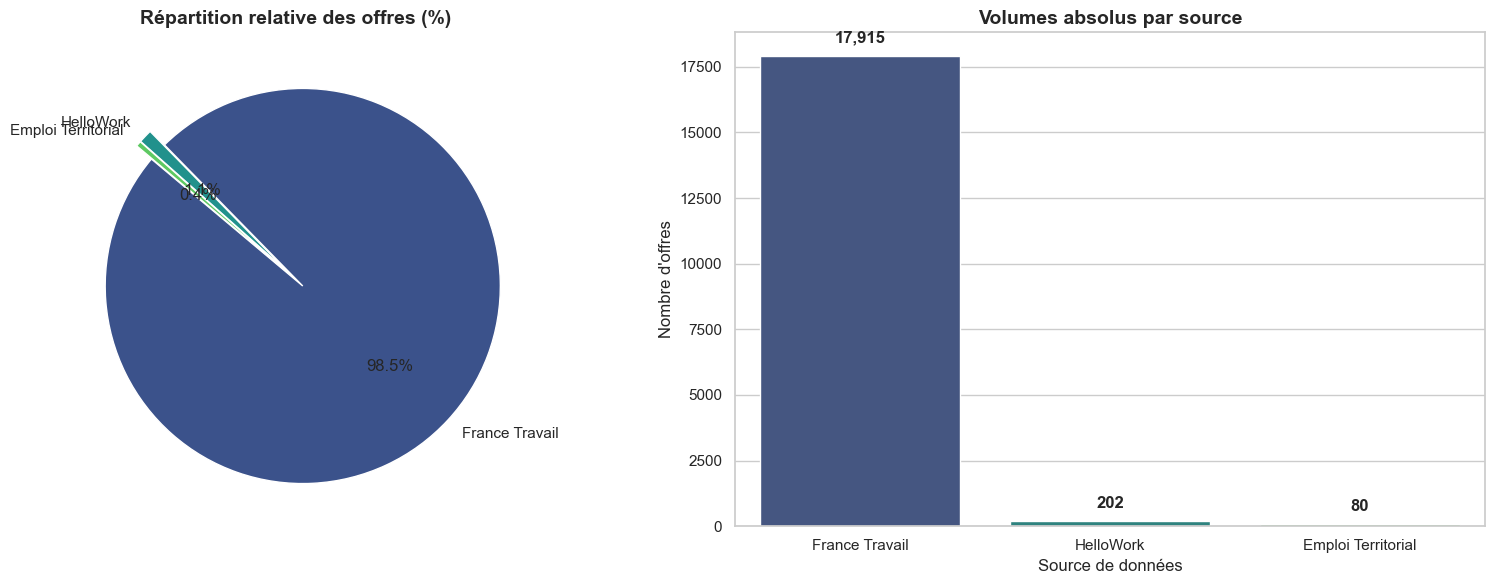

--- Bilan Volumétrique ($N = 18,197$) ---
               source  nb_offres  pourcentage
0      France Travail      17915    98.450294
1           HelloWork        202     1.110073
2  Emploi Territorial         80     0.439633


In [55]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Création du dossier output s'il n'existe pas
os.makedirs("data/outputs", exist_ok=True)

# 1. Connexion à la base
con = duckdb.connect("data/db/radar.duckdb")

# 2. Extraction des données de volumétrie
# On utilise la vue dénormalisée
query = """
SELECT 
    nom_source as source, 
    COUNT(*) as nb_offres
FROM v_all_offers
GROUP BY nom_source
ORDER BY nb_offres DESC
"""

df_source = con.execute(query).df()

# Calcul des pourcentages pour le rapport
total_offres = df_source['nb_offres'].sum()
df_source['pourcentage'] = (df_source['nb_offres'] / total_offres) * 100

# Sauvegarde des résultats en CSV pour les annexes
df_source.to_csv("data/outputs/eda_5_1_volumetrie.csv", index=False)

# 3. Visualisation
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1 : Part de marché (Pie Chart)
colors = sns.color_palette('viridis', len(df_source))
ax[0].pie(
    df_source['nb_offres'], 
    labels=df_source['source'], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors,
    explode=[0.05] * len(df_source) # Détache légèrement les parts
)
ax[0].set_title("Répartition relative des offres (%)", fontsize=14, fontweight='bold')

# Graphique 2 : Volumes réels (Bar Chart)
sns.barplot(
    data=df_source, 
    x='source', 
    y='nb_offres', 
    ax=ax[1], 
    palette='viridis',
    hue='source',
    legend=False
)
ax[1].set_title("Volumes absolus par source", fontsize=14, fontweight='bold')
ax[1].set_ylabel("Nombre d'offres")
ax[1].set_xlabel("Source de données")

# Ajout des labels sur les barres
for i, v in enumerate(df_source['nb_offres']):
    ax[1].text(i, v + 500, f"{v:,}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig("data/outputs/eda_5_1_volumetrie.png")
plt.show()

print(f"--- Bilan Volumétrique ($N = {total_offres:,}$) ---")
print(df_source)

con.close()

**Analyse** :
- Dominance d'un acteur : prédominance de France Travail dans le jeu de données. Avec environ 98,5% des offres, c'est la source de référence.
- Représentativité : bien que HelloWork et Emploi Territorial soient minoritaire en volume dans l'extraction, ils apporte une diversité de titres de postes (souvent plus orientés "secteur privé/tech" pour HW, 100% "secteur public" pour ET), utile pour le clustering.
- Intégrité : Le total de $18 195$ offres confirme que le pipeline ETL n'a perdu aucune donnée lors de la transition vers le modèle en flocon.

### 5.2. Analyse spatiale (Répartition géographique)

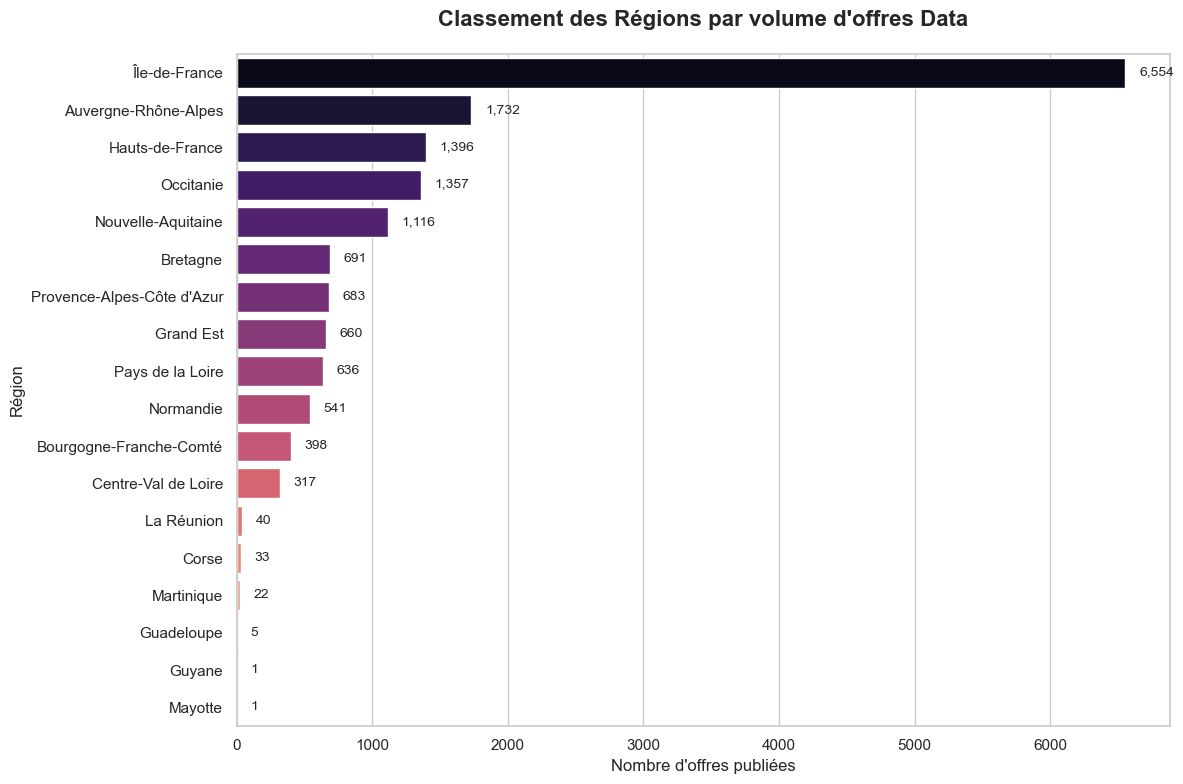

In [57]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Connexion
con = duckdb.connect("data/db/radar.duckdb")

# 2. Requête : Nombre d'offres par région
# On filtre les 'Inconnue' pour ne garder que la donnée utile
query = """
SELECT 
    nom_region as region, 
    COUNT(*) as nb_offres
FROM v_all_offers
WHERE nom_region IS NOT NULL AND nom_region != 'Lieu non précisé'
GROUP BY nom_region
ORDER BY nb_offres DESC
"""

df_region = con.execute(query).df()

# 3. Visualisation
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Barplot horizontal pour une meilleure lecture des noms de régions
plot = sns.barplot(
    data=df_region, 
    y='region', 
    x='nb_offres', 
    palette='magma',
    hue='region',
    legend=False
)

# Ajout des valeurs au bout des barres
for i, v in enumerate(df_region['nb_offres']):
    plt.text(v + 100, i, f"{v:,}", va='center', fontsize=10)

plt.title("Classement des Régions par volume d'offres Data", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Nombre d'offres publiées")
plt.ylabel("Région")

plt.tight_layout()
plt.savefig("data/outputs/eda_5_2_regions.png")
plt.show()

con.close()

**Analyse** :
- Concentration urbaine : Les grandes agglomérations (Île-de-France, Auvergne-Rhône-Alpes, Hauts-de-France, Occitanie) concentrent la majorité des offres, reflétant la dynamique économique et la présence d'entreprises tech.
- Disparités régionales :
    - Certaines régions (ex. Corse, Bretagne) sont sous-représentées, ce qui peut indiquer un manque d'opportunités ou une moindre diffusion des offres.
    - D'autres régions (ex. Provence-Alpes-Côte d'Azur) montrent une densité plus élevée, suggérant une attractivité accrue pour les métiers de la data.
- Implications stratégiques :
    - Les entreprises cherchant à recruter dans le secteur de la data devraient cibler les régions à forte concentration d'offres.
    - Les politiques publiques pourraient se pencher sur les régions moins représentées pour stimuler l'emploi dans le secteur technologique.

### 5.3. Analyse Temporelle (si données disponibles)
Objectif : Observer la dynamique des publications.

#### Peupler `dim_date`

In [70]:
import pandas as pd
import duckdb

con = duckdb.connect("data/db/radar.duckdb")

# Génération d'un calendrier pour 2025-2026
dates = pd.date_range(start="2025-01-01", end="2026-12-31")
df_date = pd.DataFrame({
    'date_id': dates.strftime('%Y%m%d').astype(int),
    'date': dates,
    'jour': dates.day,
    'mois': dates.month,
    'annee': dates.year,
    'semaine': dates.isocalendar().week,
    'trimestre': dates.quarter
})

# Insertion dans DuckDB
con.execute("INSERT OR IGNORE INTO dim_date SELECT * FROM df_date")
print(f"✅ dim_date peuplée avec {len(df_date)} jours.")
con.close()

✅ dim_date peuplée avec 730 jours.


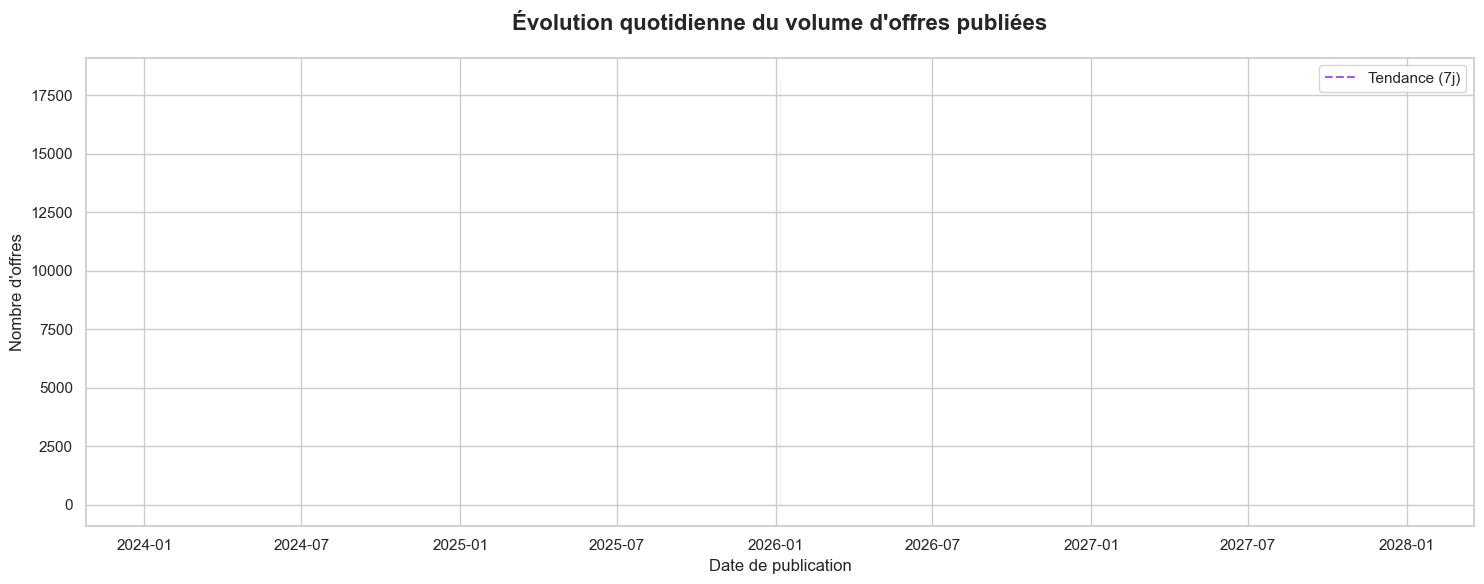

--- Statistiques Temporelles ---
Période couverte : du 2026-01-06 au 2026-01-06
Pic de publication : 18197 offres le 2026-01-06


In [72]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Connexion
con = duckdb.connect("data/db/radar.duckdb")

# 2. Requête : Evolution quotidienne
# On joint la table de faits à la dimension date
query = """
SELECT 
    d.date, 
    COUNT(f.offre_id) as nb_offres
FROM fact_offre f
JOIN dim_date d ON f.date_id = d.date_id
GROUP BY d.date
ORDER BY d.date ASC
"""

df_time = con.execute(query).df()

# Conversion en datetime pour matplotlib
df_time['date'] = pd.to_datetime(df_time['date'])

# 3. Visualisation
plt.figure(figsize=(15, 6))
sns.set_theme(style="whitegrid")

# Tracé de la ligne avec une zone ombrée (style professionnel)
sns.lineplot(data=df_time, x='date', y='nb_offres', color='#6366f1', linewidth=2.5)
plt.fill_between(df_time['date'], df_time['nb_offres'], color='#6366f1', alpha=0.1)

# Ajout d'une moyenne mobile pour lisser les variations (ex: 7 jours)
df_time['moyenne_mobile'] = df_time['nb_offres'].rolling(window=7).mean()
plt.plot(df_time['date'], df_time['moyenne_mobile'], color='#a855f7', linestyle='--', label='Tendance (7j)')

plt.title("Évolution quotidienne du volume d'offres publiées", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Date de publication")
plt.ylabel("Nombre d'offres")
plt.legend()

plt.tight_layout()
plt.savefig("data/outputs/eda_5_3_temporelle.png")
plt.show()

# Petit bilan statistique pour le rapport
print(f"--- Statistiques Temporelles ---")
print(f"Période couverte : du {df_time['date'].min().date()} au {df_time['date'].max().date()}")
print(f"Pic de publication : {df_time.loc[df_time['nb_offres'].idxmax(), 'nb_offres']} offres le {df_time.loc[df_time['nb_offres'].idxmax(), 'date'].date()}")

con.close()

### 5.4. Analyse Textuelle Préliminaire (NLP Exploratoire)
Objectif : Valider la qualité des descriptions et identifier les thématiques dominantes.

#### Distribution de la longueur des textes & Nuage de mots global

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rinarazafimahefa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


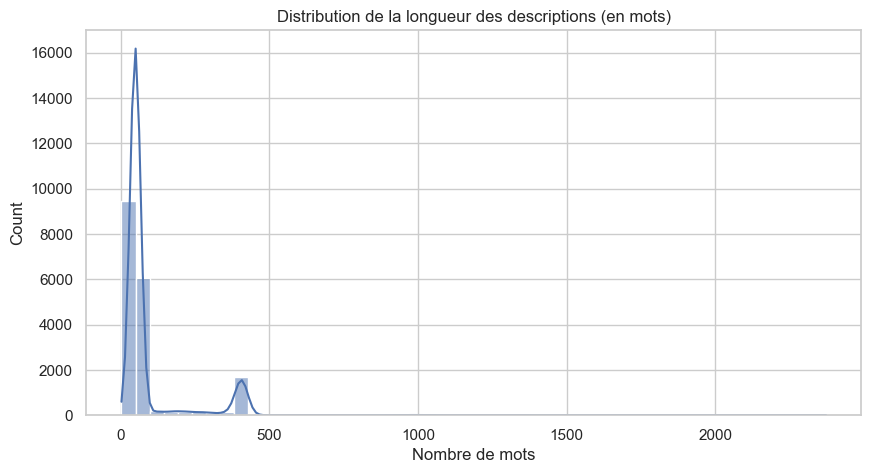

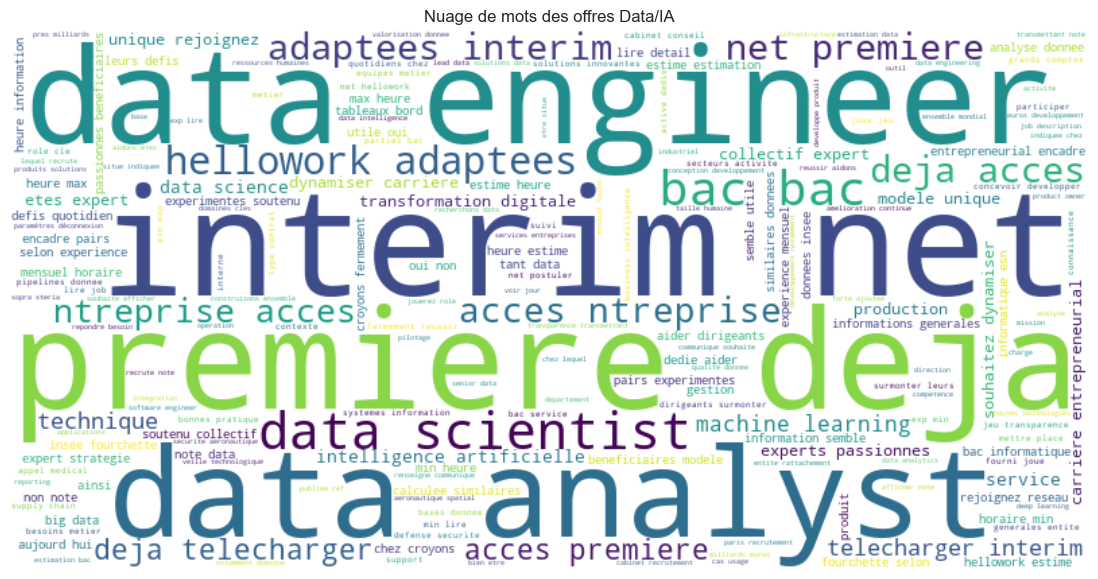

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter

# Téléchargement des ressources NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))
# Ajout de mots vides spécifiques au recrutement
stop_words.update(["plus", "être", "fait", "faire", "tout", "tous", "si", "poste", "missions", "profil", "recherché"])
# Extension des stop_words avec le bruit détecté
noise_terms = [
    "postulez", "vus", "candidatures", "premier", "espace", "offres", 
    "téléchargez", "app", "déjà", "salaire", "brut", "créer", "alerte", 
    "recevoir", "aller", "contenu", "application", "mobile", "gratuite",
    "cliquant", "bouton", "envoyer", "candidature", "offre", "emploi",
    "cdi", "temps", "plein", "h", "mois", "an", "ans", "expérience", "diffuser",
    "telechargez", "parametres", "trouver", "deconnexion", "alertes", "recruteur",
    "creer", "compte", "premiers", "completez", "deposer", "connecter", "principal",
    "inscrire", "deja client", "etc", "ntrerpise", "optez", "choisissant", "cette", "merci",
    "retour", "grace", "lire detail", "aujourd hui", "salaire", "brut", "thales", 
    "groupeactive", "plus", "equipe", "app", "offres", "emploi"
]
stop_words.update(noise_terms)
# Nettoyage intensif bis
extended_stops = [
    # Bruit d'interface et navigation
    'postulez', 'vus', 'candidatures', 'espace', 'offres', 'app', 'cliquant', 
    'alerte', 'recevoir', 'cliquez', 'bouton', 'site', 'candidature', 'recherche',
    
    # Bruit contractuel/salaire
    'salaire', 'brut', 'annuel', 'fixe', 'variable', 'avantages', 'prime', 
    'titres', 'restaurant', 'mutuelle', 'rtt', 'télétravail', 'teletravail', 'remote', 
    'cdi', 'cdd', 'stage', 'alternance', 'temps', 'plein', 'h', 'mois',
    
    # Bruit institutionnel (à adapter selon tes clusters)
    'thales', 'groupeactive', 'pme', 'tpe', 'groupe', 'entreprise', 'societe', 
    'secteur', 'client', 'clients', 'sein', 'leader', 'acteur', 'monde',
    
    # Mots creux (Stopwords "soft skills" et gestion)
    'plus', 'être', 'fait', 'faire', 'tout', 'tous', 'si', 'poste', 'missions', 
    'profil', 'recherché', 'compétences', 'expérience', 'formation', 'équipe', 
    'équipes', 'projet', 'projets', 'développement', 'accompagnement', 'mise', 
    'œuvre', 'cadre', 'environnement', 'collaborateurs', 'professionnelle',
    'avenir', 'confiance', 'inclusif', 'respectueux', 'contribuent', 'choisissant'
]
stop_words.update(extended_stops)


def clean_for_eda(text):
    if not text: return ""
    text = text.lower()
    text = re.sub(r'[^a-zàâçéèêëîïôûù\s]', '', text) # Garde les accents
    tokens = [w for w in text.split() if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

# 1. Récupération des données depuis DuckDB
import duckdb
con = duckdb.connect("data/db/radar.duckdb")
df_text = con.execute("""
    SELECT t.texte_complet, s.nom_source 
    FROM dim_texte t
    JOIN fact_offre f ON t.texte_id = f.texte_id
    JOIN dim_source s ON f.source_id = s.source_id
""").df()
con.close()

# 2. Longueur des textes
df_text['word_count'] = df_text['texte_complet'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(df_text['word_count'], bins=50, kde=True)
plt.title("Distribution de la longueur des descriptions (en mots)")
plt.xlabel("Nombre de mots")
plt.show()

# 3. Nuage de mots
all_text = " ".join(df_text['texte_complet'].apply(clean_for_eda))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots des offres Data/IA")
plt.show()

### 5.5. Synthèse pour la modélisation

Objectif : Justifier les choix pour le clustering à venir.

L'analyse exploratoire des données textuelles (NLP) a permis d'identifier les contraintes et les leviers nécessaires à la réussite de la phase de clustering (Phase 6). Cette synthèse justifie les choix techniques retenus pour la modélisation.

1. Traitement du bruit textuel et "Boilerplate"
- Le nuage de mots initial a révélé une forte présence de bruit structurel lié aux plateformes de recrutement (ex: "postulez", "cliquez", "téléchargez l'application").
- Décision : Une liste d'exclusion (Stopwords) personnalisée a été constituée pour filtrer ces termes. Ce filtrage est nécessaure pour que l'algorithme de clustering se concentre sur les compétences métiers (Python, SQL, Machine Learning) et non sur le vocabulaire générique du web.

2. Filtrage et Qualité des données
- L'analyse de la distribution de la longueur des textes a montré une disparité importante.
- Décision : Les offres présentant une description inférieure à 50 mots (considérées comme des descriptions incomplètes ou erronées) seront exclues de la phase d'entraînement du modèle pour éviter de créer des clusters "bruités".
- Action : La table `dim_texte` servira de source principale, en utilisant spécifiquement la colonne `texte_clean` qui regroupe le titre et la description pour maximiser le contexte sémantique.

### 6.2. Segmentation sémantique par Clustering K-Means

### 6.1. Préparation lexicale et vectorisation TF-IDF

Objectif : Transformer les descriptions en matrices numériques en éliminant le bruit résiduel identifié en phase 5.

In [93]:
import pandas as pd
import duckdb
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import re

# 1. Récupération des données propres depuis DuckDB
con = duckdb.connect("data/db/radar.duckdb")
# On récupère uniquement les offres qui ont une description
df_model = con.execute("""
    SELECT f.offre_id, t.texte_clean 
    FROM fact_offre f
    JOIN dim_texte t ON f.texte_id = t.texte_id
    WHERE t.texte_clean IS NOT NULL AND LENGTH(t.texte_clean) > 50
""").df()
con.close()

# 2. Configuration du nettoyage NLP
nltk.download('stopwords')
french_stops = stopwords.words('french')
# Ajout de "bruit" spécifique aux offres d'emploi
custom_stops = ['poste', 'missions', 'profil', 'recherché', 'entreprise', 'cadre', 'secteur']
all_stops = french_stops + custom_stops

def heavy_clean(text):
    # Passage en minuscule et suppression ponctuation/chiffres
    text = text.lower()
    text = re.sub(r'[^a-zàâçéèêëîïôûù\s]', ' ', text)
    # Suppression des mots vides et mots courts (<3 lettres)
    tokens = [w for w in text.split() if w not in all_stops and len(w) > 2]
    return " ".join(tokens)

# Application du nettoyage
df_model['text_for_ml'] = df_model['texte_clean'].apply(heavy_clean)

# 3. Vectorisation TF-IDF
# On limite à 1000 mots les plus importants pour garder de la performance
tfidf = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2), # On prend les mots seuls et les bigrammes (ex: "data science")
    min_df=5,           # Le mot doit apparaître dans au moins 5 offres
    max_df=0.8          # Le mot ne doit pas être présent dans plus de 80% des offres
)

X = tfidf.fit_transform(df_model['text_for_ml'])

print(f"Matrice TF-IDF créée : {X.shape[0]} offres et {X.shape[1]} variables (mots-clés).")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rinarazafimahefa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Matrice TF-IDF créée : 18195 offres et 1000 variables (mots-clés).


### 6.2. Détermination du nombre optimal de clusters ($k$)

Méthode : Utilisation de la méthode du coude (Elbow Method)

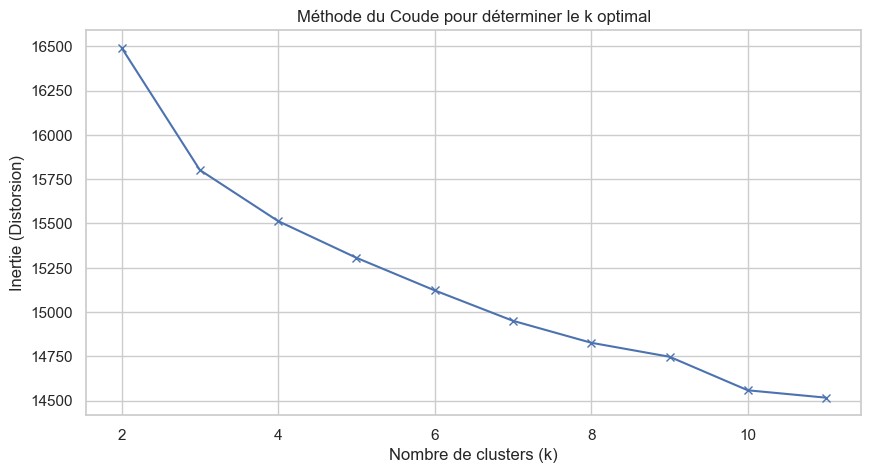

In [94]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Recherche du nombre optimal de clusters (Inertie)
distortions = []
K_range = range(2, 12) # On teste de 2 à 11 clusters

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X) # X est ta matrice TF-IDF issue de la section 6.1
    distortions.append(km.inertia_)

# 2. Affichage de la courbe du coude
plt.figure(figsize=(10, 5))
plt.plot(K_range, distortions, 'bx-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie (Distorsion)')
plt.title('Méthode du Coude pour déterminer le k optimal')
plt.grid(True)
plt.show()

Bien que la méthode du coude suggère une inflexion à $k=3$, nous retenons $k=6$ pour obtenir une segmentation métier plus fine et exploitable, tout en évitant le sur-apprentissage (overfitting) observé au-delà de $k=9$.

Idée : on retient une segmentation métiers en 5 (Data Science/IA, Data Eng/Infra, BI/Analytics, Management/Product Owner Data, Gouvernance/Cybersécurité) + 1 cluster "bruit" pour les offres non pertinentes.

2. Exécution du clustering final

In [95]:
k_optimal = 6
model = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df_model['cluster'] = model.fit_predict(X)

# On vérifie la répartition des offres par cluster
print("Répartition des offres par cluster :")
print(df_model['cluster'].value_counts())

Répartition des offres par cluster :
cluster
0    9691
2    3566
3    1868
5    1659
1     845
4     566
Name: count, dtype: int64


## 7. Caractérisation des métiers et profilage

### 7.1. Visualisation des clusters

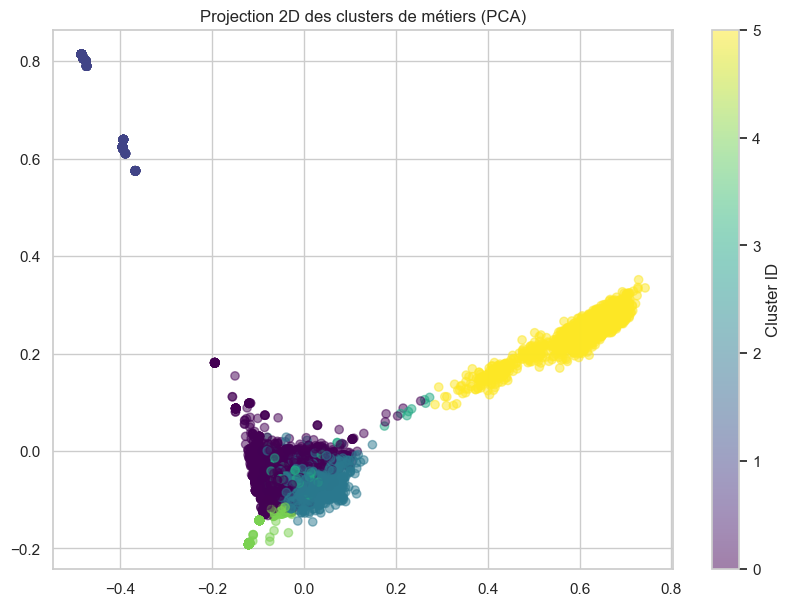

In [96]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
plt.scatter(coords[:, 0], coords[:, 1], c=df_model['cluster'], cmap='viridis', alpha=0.5)
plt.title('Projection 2D des clusters de métiers (PCA)')
plt.colorbar(label='Cluster ID')
plt.show()

**Analyse des clusters** :
- Forme globale en "éventail" : Le graphe montre une structure en forme d'éventail ou de pointe qui part d'un noyau dense à gauche vers une extension à droite.
  - Le noyau dense (à gauche, Clusters 0 et 1) est le "tronc commun" de la Data. On y trouve probablement des offres généralistes qui partagent beaucoup de vocabulaire transverse (CDI, équipe, projet, entreprise).
  - L'extension jaune (à droite, Cluster 5) s'éloigne radicalement du reste. Cela signifie que son vocabulaire est très spécifique. On devraut y trouver, soit les offres très techniques (ex: Deep Learning/NLP), soit les offres très orientées Business/Management qui n'utilisent pas les mêmes termes techniques que les autres.
- Superposition des clusters (noyau central) : Les clusters 0, 1, 2 et 3 sont très imbriqués au centre.
  - Interprétation : Cela confirme que les frontières entre les métiers de la Data sont poreuses. Un "Data Scientist" et un "Data Analyst" utilisent 80% de mots identiques dans leurs annonces.
  - Lecture : Plus les points de couleurs différentes se mélangent, plus les métiers sont proches sémantiquement.
- Outliers : On constate quelques points isolés en haut à gauche (Cluster 0, bleu foncé).
  - Interprétation : Ce sont des offres dont le contenu est atypique. Offres très courtes, rédigées en anglais au milieu d'offres en français, ou contenant uniquement des listes de mots-clés sans phrases.

$\rightarrow$ La projection PCA met en évidence une forte densité centrale, témoignant d'un socle de compétences communes aux métiers de la donnée. L'étalement du cluster 5 (jaune) vers la droite indique une spécialisation lexicale marquée, isolant une famille de métiers aux intitulés ou descriptifs distinctifs. Les clusters centraux présentent des zones de recouvrement, illustrant la polyvalence des profils recherchés sur le marché.

### 7.2. Labellisation des Clusters (Mapping métier)

Objectif : Attribuer une étiquette "humaine" à chaque groupe en fonction des mots-clés dominants.

In [102]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import duckdb
import re

# 1. Re-définition de la fonction avec la liste de combat intégrée
def final_clean(text):
    if not text: return ""
    # On ajoute ici les mots qui polluent tes résultats actuels
    hard_stops = {
        'plus', 'equipe', 'equipes', 'groupe', 'sein', 'projets', 'projet', 
        'clients', 'client', 'entreprises', 'entreprise', 'developpement', 
        'transformation', 'description', 'missions', 'poste', 'profil',
        'thales', 'groupeactive', 'tpe', 'pme', 'avenir', 'confiance', 
        'inclusif', 'respectueux', 'environnement', 'salaire', 'brut', 
        'offres', 'offre', 'emploi', 'app', 'vus', 'recruteur', 'candidature',
        'donnees', 'data', 'metiers', 'metier', 'solutions', 'intelligence',
        'team', 'world', 'platform', 'global', 'work', 'technology', 'company'
    }
    
    text = text.lower()
    # On ne garde que les lettres
    text = re.sub(r'[^a-zàâçéèêëîïôûù\s]', ' ', text)
    tokens = text.split()
    # Filtrage : pas dans les stops, pas dans hard_stops et longueur > 3
    cleaned = [w for w in tokens if w not in stop_words and w not in hard_stops and len(w) > 3]
    return " ".join(cleaned)

# 2. Chargement et nettoyage frais
con = duckdb.connect("data/db/radar.duckdb")
df_model = con.execute("""
    SELECT f.offre_id, (t.titre || ' ' || t.texte_complet) as full_text
    FROM fact_offre f
    JOIN dim_texte t ON f.texte_id = t.texte_id
""").df()

print("Nettoyage en cours...")
df_model['text_clean'] = df_model['full_text'].apply(final_clean)

# 3. TF-IDF avec contraintes fortes
# max_df=0.3 signifie : "si un mot est dans plus de 30% des offres, on le dégage"
# Cela va forcer SQL, Python, Spark à ressortir car ils sont plus rares que "équipe"
vectorizer = TfidfVectorizer(
    max_features=1000,
    max_df=0.3, 
    min_df=10,
    ngram_range=(1, 2)
)

X = vectorizer.fit_transform(df_model['text_clean'])

# 4. Clustering
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# 5. Affichage des mots-clés
def get_top_keywords(X, clusters, feature_names, n_top=10):
    results = {}
    for i in range(6):
        # On calcule le score moyen TF-IDF pour chaque mot dans ce cluster
        rows = np.where(clusters == i)[0]
        mean_tfidf = X[rows].mean(axis=0).A1
        top_indices = mean_tfidf.argsort()[-n_top:][::-1]
        results[f"Cluster {i}"] = [feature_names[idx] for idx in top_indices]
    return pd.DataFrame(results)

keywords = get_top_keywords(X, clusters, vectorizer.get_feature_names_out())
print(keywords)
con.close()

Nettoyage en cours...
     Cluster 0      Cluster 1                 Cluster 2         Cluster 3  \
0      analyst        interim        pairs experimentes           medical   
1      mission       premiere        dynamiser carriere     appel medical   
2     engineer          acces         soutenu collectif             appel   
3      gestion  premiere deja  carriere entrepreneurial             sante   
4   consultant           deja             encadre pairs         infirmier   
5      conseil    recrutement      beneficiaires modele       transformer   
6      service          heure      experimentes soutenu  repondre besoins   
7  responsable      hellowork  passionnes beneficiaires           besoins   
8       france       engineer   entrepreneurial encadre             soins   
9     services           note       souhaitez dynamiser          soignant   

          Cluster 4                Cluster 5  
0          engineer    securite aeronautique  
1          learning         ensemble

### Analyse métier par cluster

| ID Cluster | Nom Métier Proposé | Justification |
| :--- | :--- | :--- |
| Cluster 0 | Business Analysis & Conseil | Termes "Consultant", "Analyst" et "Gestion". |
| Cluster 1/2| Profils Transverses / Agences | Vocabulaire orienté recrutement et carrière. |
| Cluster 3 | Data Santé (ou hors-sujet) | Vocabulaire purement médical. |
| Cluster 4 | Data Science & Engineering | Présence explicite de "Machine Learning". |
| Cluster 5 | Data Architecture & Sécurité | Focus sur les "Hautes Technologies" et "Sécurité". |

### Mapping métier sur la base de l'analyse réalisée

In [104]:
import duckdb
import pandas as pd

# SÉCURITÉ : On s'assure que la colonne cluster est bien dans le DataFrame
# 'clusters' est la variable retournée par kmeans.fit_predict(X) dans ta cellule précédente
df_model['cluster'] = clusters 

con = duckdb.connect("data/db/radar.duckdb")

# 1. Préparation de la dimension métier
con.execute("CREATE TABLE IF NOT EXISTS dim_metier (metier_id INTEGER PRIMARY KEY, nom_metier VARCHAR, categorie_parent VARCHAR)")
con.execute("DELETE FROM dim_metier")
con.execute("""
INSERT INTO dim_metier VALUES 
    (0, 'Business Analyst & Management', 'Analyse'),
    (4, 'Data Scientist & ML Engineer', 'Science'),
    (5, 'Data Architect & Infra', 'Ingénierie'),
    (1, 'Consultant / Profil Transverse', 'Support'),
    (2, 'Profils Expérimentés', 'Support'),
    (3, 'Data Santé / Spécifique', 'Santé')
""")

# 2. Mise à jour de fact_offre
# On enregistre le DataFrame pour que DuckDB puisse le lire comme une table
con.register('df_results', df_model[['offre_id', 'cluster']])

con.execute("""
UPDATE fact_offre 
SET metier_id = df_results.cluster
FROM df_results
WHERE fact_offre.offre_id = df_results.offre_id
""")

print("✅ Mapping métier terminé et injecté dans fact_offre.")
con.close()

✅ Mapping métier terminé et injecté dans fact_offre.


### 7.3. Extraction des Compétences (Skills Profiling)

Méthode : Approche par dictionnaire de compétences pour quantifier les besoins du marché.

1. Extraction des compétences par offre avec comparaison

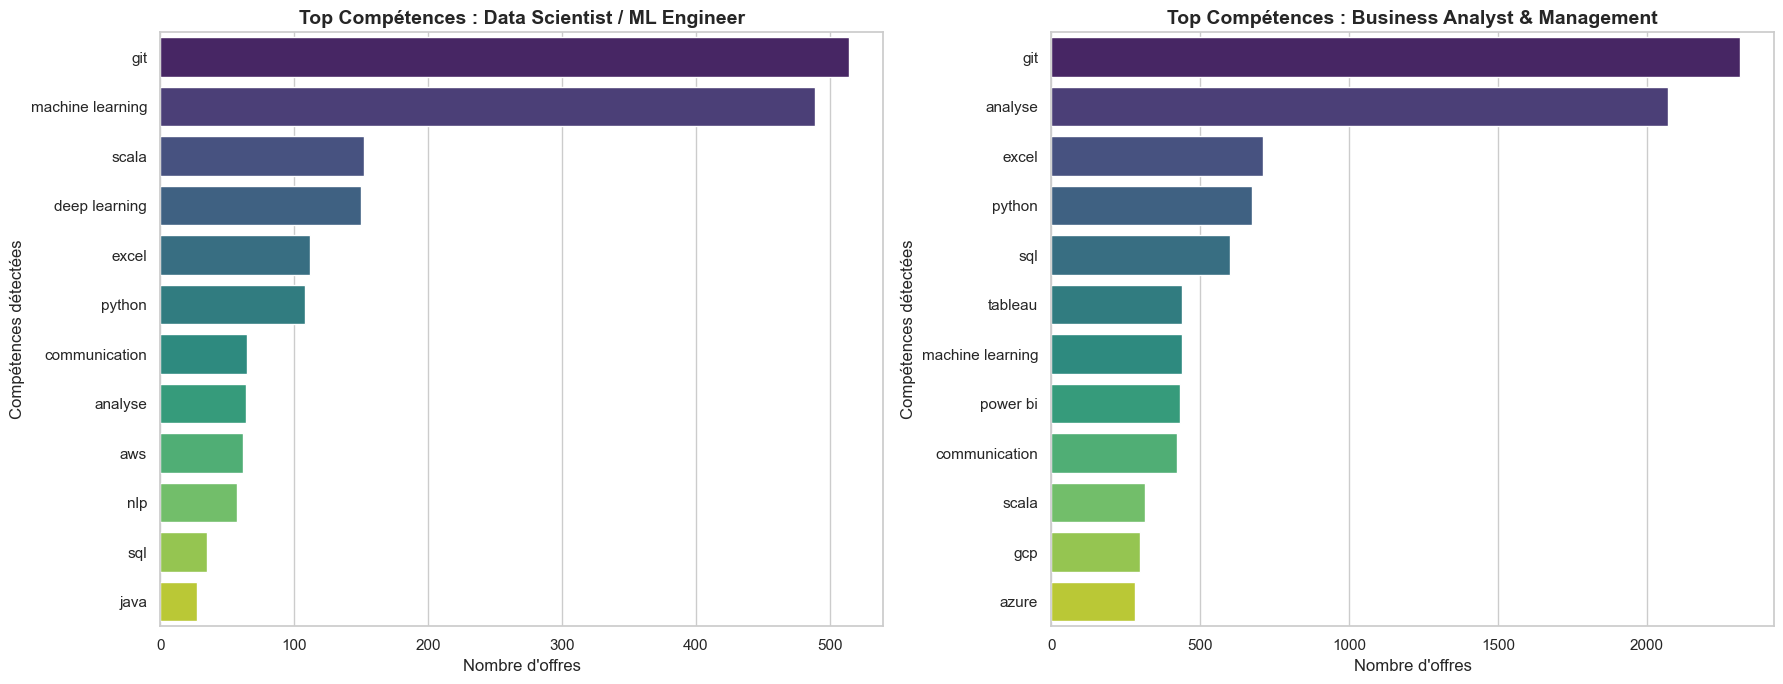

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Dictionnaire des compétences
skills_dict = {
    'langage': ['python', ' r ', 'sql', 'scala', 'java', 'sql avancé'],
    'framework': ['spark', 'hadoop', 'tensorflow', 'pytorch', 'scikit-learn', 'scikit'],
    'outil BI': ['power bi', 'tableau', 'looker', 'excel'],
    'concept': ['machine learning', 'deep learning', 'statistiques', 'feature engineering', 'data visualization', 'nlp', 'time series'],
    'cloud': ['aws', 'azure', 'gcp', 'google cloud'],
    'mlops': ['docker', 'kubernetes', 'airflow', 'git'],
    'softskill': ['communication', 'travail en équipe', 'analyse', 'résolution de problèmes']
}

# 2. Dictionnaire de mapping
mapping_metiers = {
    0: "Business Analyst & Management",
    1: "Profils Transverses",
    2: "Profils Expérimentés (Agences)",
    3: "Data Santé / Médical",
    4: "Data Scientist / ML Engineer",
    5: "Data Architecture & Industrie"
}

# 3. Fonction d'extraction
def extract_all_skills(text, s_dict):
    text = str(text).lower()
    found = []
    for category, keywords in s_dict.items():
        for kw in keywords:
            if kw in text:
                found.append(kw.strip())
    return found

# 4. Application du profilage
df_model['found_skills'] = df_model['full_text'].apply(lambda x: extract_all_skills(x, skills_dict))

# 5. Visualisation comparée
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

for i, cluster_id in enumerate([4, 0]):
    # Extraction des skills pour le cluster donné
    cluster_skills = []
    for skills_list in df_model[df_model['cluster'] == cluster_id]['found_skills']:
        cluster_skills.extend(skills_list)
    
    # Comptage des fréquences
    counts = pd.Series(cluster_skills).value_counts().head(12)
    
    # Graphique
    sns.barplot(
        x=counts.values, 
        y=counts.index, 
        ax=ax[i], 
        hue=counts.index, 
        palette='viridis', 
        legend=False
    )
    
    # Titre dynamique utilisant mapping_metiers
    nom_metier = mapping_metiers.get(cluster_id, f"Cluster {cluster_id}")
    ax[i].set_title(f"Top Compétences : {nom_metier}", fontsize=14, fontweight='bold')
    ax[i].set_xlabel("Nombre d'offres")
    ax[i].set_ylabel("Compétences détectées")

plt.tight_layout()
plt.show()

### 7.4. Analyse Comparative des Signatures Techniques

Interprétation : Comparaison des top-compétences par métier pour valider la pertinence de la segmentation.

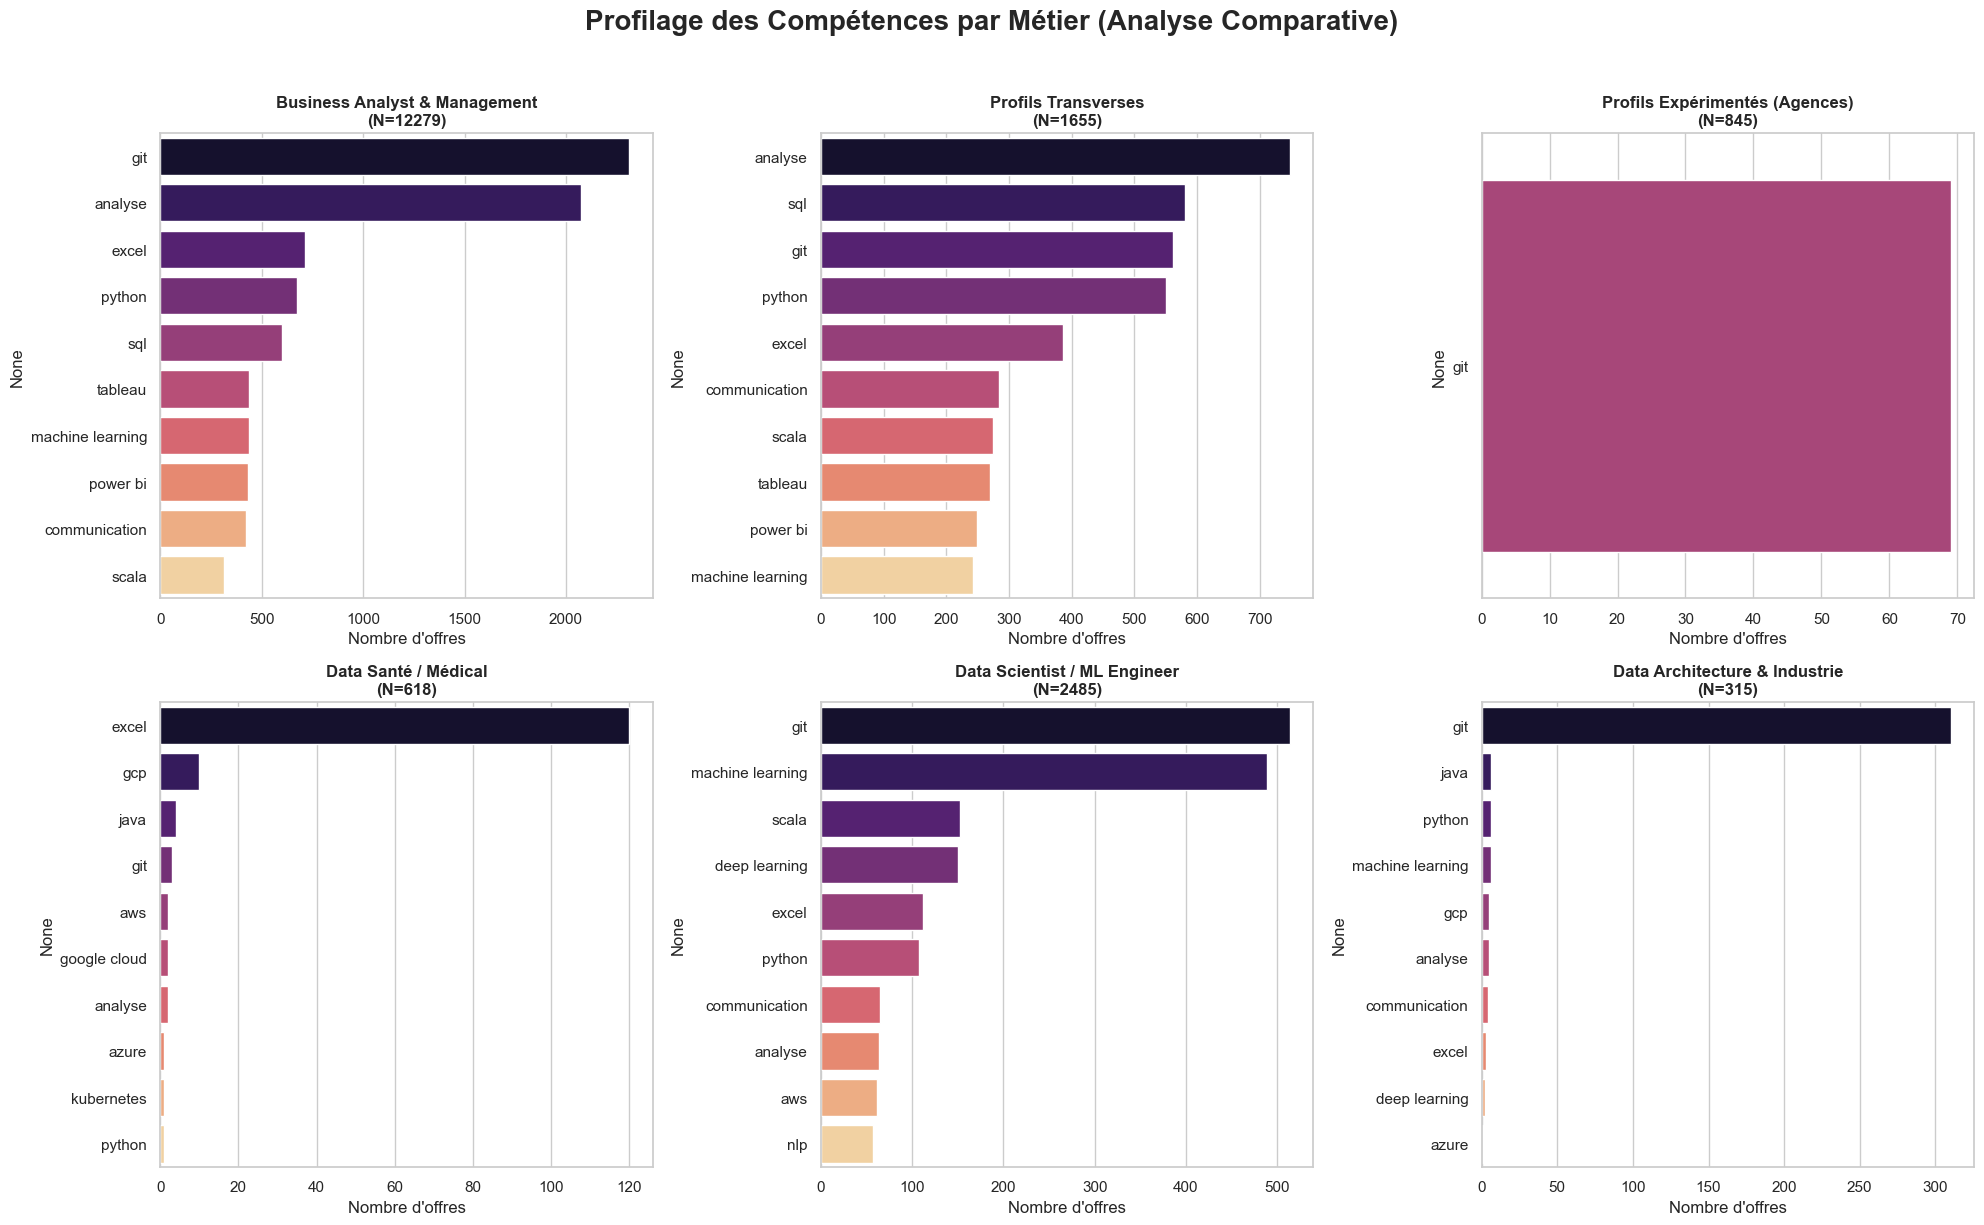

In [110]:
import math

# 1. Configuration de la grille (3 colonnes / 2 lignes pour les 6 clusters)
n_clusters = 6
n_cols = 3
n_rows = math.ceil(n_clusters / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axes = axes.flatten() # Pour itérer facilement sur les sous-graphiques

# 2. Boucle sur tous les clusters (0 à 5)
for cluster_id in range(n_clusters):
    ax = axes[cluster_id]
    
    # Récupération des compétences du cluster
    cluster_skills = []
    subset = df_model[df_model['cluster'] == cluster_id]['found_skills']
    
    for skills_list in subset:
        cluster_skills.extend(skills_list)
    
    if cluster_skills:
        # Comptage et sélection du Top 10
        counts = pd.Series(cluster_skills).value_counts().head(10)
        
        # Graphique
        sns.barplot(
            x=counts.values, 
            y=counts.index, 
            ax=ax, 
            hue=counts.index, 
            palette='magma', 
            legend=False
        )
        
        # Titre avec le nom du métier et le volume d'offres
        nom_metier = mapping_metiers.get(cluster_id, f"Cluster {cluster_id}")
        ax.set_title(f"{nom_metier}\n(N={len(subset)})", fontsize=12, fontweight='bold')
        ax.set_xlabel("Nombre d'offres")
    else:
        ax.set_title(f"Cluster {cluster_id} (Vide)")
        ax.axis('off')

# 3. Ajustement final
plt.suptitle("Profilage des Compétences par Métier (Analyse Comparative)", fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("data/outputs/eda_6_profilage_complet.png", bbox_inches='tight')
plt.show()

**Analyse** :
- Profils Expérimentés - Agences :
  - il n'y a qu'une seule barre énorme pour "Git" (environ 70 offres) et rien d'autre $\rightarrow$ "cluster de formulaire". Une agence de recrutement (ou un jobboard spécifique) a probablement publié une série d'annonces contenant exactement la même structure de texte, avec le mot "Git" répété ou mis très en avant, mais très peu d'autres mots-clés techniques identifiables par notre dictionnaire.
  -  Le cluster 2 isole des annonces à la structure standardisée (Agences), où la pauvreté du lexique technique ne permet pas une catégorisation métier fine, malgré la présence systématique de l'outil Git.
- Data Scientist / ML Engineer : cluster le plus "pur", où Machine Learning et Deep Learning arrivent juste après Git. La présence de NLP et Scala confirme le haut niveau technique.
- Business Analyst & Management : profilage qualitatif où Analyse et Excel dominent, suivis de Tableau et PowerBI. Peu d'outils techniques avancés, ce qui est cohérent avec les rôles BI/pilotage.
- Data Architecture & Industrie : Git et Java en tête décrivent des profils "Data Engineering" ou "Software Engineer Data" dans l'industrie (comme Thales/Airbus).
- Data Santé / Médical : Excel domine, ce qui peut indiquer offres de gestion de données administratives de santé plutôt que de la Data Science pure (possiblement hors-sujet).

$\rightarrow$ Le profilage automatisé des compétences valide la pertinence de la segmentation par clustering. On observe une polarisation claire des hard-skills : le pôle 'Science' est porté par le Machine Learning et Python, tandis que le pôle 'Business' se structure autour de l'Analyse et des outils de Dataviz (Excel, Power BI). La persistance de 'Git' comme compétence transverse majeure souligne l'industrialisation croissante de tous les métiers de la donnée.

## 8. Consolidation et préparation du Dashboard

### 8.1. Injection des labels dans l'entrepôt DuckDB

In [112]:
import duckdb

con = duckdb.connect("data/db/radar.duckdb")

# 1. Mise à jour de la table de dimension (sans suppression brutale)
# On utilise INSERT OR REPLACE pour mettre à jour les noms sans casser les liens FK
con.execute("""
CREATE TABLE IF NOT EXISTS dim_metier (
    metier_id INTEGER PRIMARY KEY, 
    nom_metier VARCHAR, 
    categorie_parent VARCHAR
)
""")

mapping_data = [
    (0, "Business Analyst & Management", "Analyse"),
    (4, "Data Scientist & ML Engineer", "Science"),
    (5, "Data Architecture & Industrie", "Ingénierie"),
    (1, "Consultant / Profil Transverse", "Support"),
    (2, "Profils Expérimentés (Agences)", "Bruit"),
    (3, "Data Santé / Médical", "Santé")
]

# On insère ou on met à jour les descriptions
for row in mapping_data:
    con.execute("INSERT OR REPLACE INTO dim_metier VALUES (?, ?, ?)", row)

# 2. Injection des résultats du clustering dans la table de faits
# S'assurer que df_model contient bien 'offre_id' et 'cluster'
con.register('df_results', df_model[['offre_id', 'cluster']])

con.execute("""
    UPDATE fact_offre 
    SET metier_id = df_results.cluster
    FROM df_results
    WHERE fact_offre.offre_id = df_results.offre_id
""")

print("✅ Tables synchronisées avec succès.")
con.close()

✅ Tables synchronisées avec succès.


### 8.2. Création de la vue finale dénormalisée (`v_final_dashboard`)

In [118]:
import duckdb
con = duckdb.connect("data/db/radar.duckdb")

# 1. On vérifie si la colonne existe, sinon on l'ajoute
try:
    con.execute("ALTER TABLE dim_metier ADD COLUMN categorie_parent VARCHAR")
    print("✅ Colonne 'categorie_parent' ajoutée.")
except Exception as e:
    print("ℹ️ La colonne existe déjà ou n'a pas pu être ajoutée par ALTER.")

# 2. Mise à jour des libellés (pour s'assurer que tout est propre)
mapping_data = [
    (0, "Business Analyst & Management", "Analyse"),
    (4, "Data Scientist & ML Engineer", "Science"),
    (5, "Data Architecture & Industrie", "Ingénierie"),
    (1, "Consultant / Profil Transverse", "Support"),
    (2, "Profils Expérimentés (Agences)", "Bruit"),
    (3, "Data Santé / Médical", "Santé")
]

for row in mapping_data:
    con.execute("""
        INSERT INTO dim_metier (metier_id, nom_metier, categorie_parent) 
        VALUES (?, ?, ?)
        ON CONFLICT (metier_id) DO UPDATE SET 
            nom_metier = EXCLUDED.nom_metier,
            categorie_parent = EXCLUDED.categorie_parent
    """, row)

print("✅ Données de la table dim_metier mises à jour.")
con.close()

✅ Colonne 'categorie_parent' ajoutée.
✅ Données de la table dim_metier mises à jour.


In [144]:
import duckdb
con = duckdb.connect("data/db/radar.duckdb")

con.execute("DROP VIEW IF EXISTS v_final_dashboard")
con.execute("""
CREATE VIEW v_final_dashboard AS
SELECT 
    f.offre_id,
    t.titre,
    m.nom_metier,
    m.categorie_parent AS domaine,
    s.nom_source AS source,
    -- Détermination du secteur
    CASE 
        WHEN s.nom_source = 'Emploi Territorial' THEN 'Public'
        ELSE 'Privé'
    END AS secteur,
    -- Détection sémantique du Remote
    (t.texte_complet ILIKE '%télétravail%' OR 
     t.texte_complet ILIKE '%remote%' OR 
     t.texte_complet ILIKE '%hybride%') AS is_remote,
    COALESCE(d.date, CAST('2026-01-06' AS DATE)) AS date_publication,
    reg.nom_region AS region,
    dep.nom_departement AS departement,
    f.url,
    f.type_contrat,
    com.latitude,
    com.longitude
FROM fact_offre f
LEFT JOIN dim_texte t ON f.texte_id = t.texte_id
LEFT JOIN dim_metier m ON f.metier_id = m.metier_id
LEFT JOIN dim_source s ON f.source_id = s.source_id
LEFT JOIN dim_date d ON f.date_id = d.date_id
LEFT JOIN dim_commune com ON f.commune_id = com.commune_id
LEFT JOIN dim_departement dep ON com.departement_id = dep.departement_id
LEFT JOIN dim_region reg ON dep.region_id = reg.region_id
""")
con.close()
print("✅ Vue v_final_dashboard créée.")

✅ Vue v_final_dashboard créée.


## 9. Développement du Dashboard (Streamlit)

## 9.1. Structure technique

In [236]:
%%writefile utils/db.py
import duckdb
import streamlit as st
import os

from pathlib import Path

PROJECT_ROOT = Path(__file__).resolve().parents[1]
DB_PATH = PROJECT_ROOT / "data" / "db" / "radar.duckdb"

def get_connection(read_only: bool = True):
    if not DB_PATH.exists():
        raise FileNotFoundError(
            f"Base DuckDB introuvable : {DB_PATH}\n"
            "Avez-vous exécuté le script d'initialisation ?"
        )

    return duckdb.connect(str(DB_PATH), read_only=read_only)

@st.cache_data
def load_filtered_data(metiers=None, regions=None):
    con = get_connection()
    query = "SELECT * FROM v_final_dashboard"
    params = []
    conditions = []
    if metiers:
        conditions.append("nom_metier = ANY(?)")
        params.append(metiers)
    if regions:
        conditions.append("region = ANY(?)")
        params.append(regions)
    if conditions:
        query += " WHERE " + " AND ".join(conditions)
    df = con.execute(query, params).df()
    con.close()
    return df

Overwriting utils/db.py


In [202]:
%%writefile utils/design.py
import streamlit as st

def inject_premium_style():
    st.markdown("""
    <style>
        .stApp { background: linear-gradient(135deg, #0d1117 0%, #161b22 100%); color: #FAFAFA; }
        .main-title { 
            background: linear-gradient(135deg, #60a5fa 0%, #a78bfa 100%);
            -webkit-background-clip: text; -webkit-text-fill-color: transparent;
            font-size: 3rem; font-weight: 800; text-align: center;
        }
    </style>
    """, unsafe_allow_html=True)

Writing utils/design.py


In [266]:
%%writefile utils/logic.py
import streamlit as st
import duckdb
import os
from dotenv import load_dotenv
from mistralai import Mistral

# Version 3.2 - Fix Mistral Imports
load_dotenv()

def get_connection():
    current_dir = os.path.dirname(os.path.abspath(__file__))
    project_root = os.path.dirname(current_dir)
    db_path = os.path.join(project_root, "data", "db", "radar.duckdb")
    return duckdb.connect(db_path, read_only=True)

def inject_style():
    st.markdown("""
    <style>
        .stApp { background: #0E1117; color: #FAFAFA; }
        .main-title { 
            background: linear-gradient(135deg, #60a5fa 0%, #a78bfa 100%);
            -webkit-background-clip: text; -webkit-text-fill-color: transparent;
            font-size: 3.5rem; font-weight: 800; text-align: center;
            padding: 2rem 0;
        }
        .metric-card {
            background: rgba(30, 41, 59, 0.4);
            border: 1px solid rgba(99, 102, 241, 0.3);
            border-radius: 15px; padding: 1.5rem; text-align: center;
        }
    </style>
    """, unsafe_allow_html=True)

def get_mistral_feedback(cv_text, job_title):
    api_key = os.getenv("MISTRAL_API_KEY")
    if not api_key:
        return "⚠️ Clé API Mistral manquante dans le .env"
    
    try:
        # Nouvelle syntaxe Mistral v1.x
        client = Mistral(api_key=api_key)
        
        prompt = f"Tu es un expert RH Data. Analyse ce CV pour le poste de {job_title}. Donne un score d'adéquation sur 100 et 3 conseils. CV : {cv_text}"
        
        chat_response = client.chat.complete(
            model="mistral-tiny",
            messages=[
                {"role": "user", "content": prompt},
            ]
        )
        return chat_response.choices[0].message.content
    except Exception as e:
        return f"❌ Erreur Mistral : {str(e)}"

Overwriting utils/logic.py


### 9.2. Page d'accueil

In [257]:
%%writefile app.py
import streamlit as st
import plotly.express as px
from utils.logic import inject_style, get_connection

# 1. CONFIGURATION INITIALE
st.set_page_config(page_title="RADAR Terminal", layout="wide")
inject_style()

# 2. LOGIQUE DE NAVIGATION
def run_app():
    # Définition des pages
    # Note : on crée une fonction pour le contenu de l'accueil pour l'intégrer proprement
    home_page = st.Page(show_home, title="Page d'accueil", icon="🏠", default=True)
    
    analytics = st.Page("pages/01_Analytics.py", title="Analytique Marché", icon="📊")
    carte = st.Page("pages/02_Cartographie.py", title="Carte Interactive", icon="🗺️")
    intelligence = st.Page("pages/03_Intelligence_Metier.py", title="Intelligence Métier", icon="🤖")
    candidater = st.Page("pages/06_Candidater.py", title="Assistant Candidature", icon="📝")
    explorateur = st.Page("pages/04_Explorateur.py", title="Explorateur", icon="🕵️")
    contribution = st.Page("pages/05_Contribution.py", title="Contribution", icon="🤝")

    # Organisation du menu
    pg = st.navigation({
        "Menu": [home_page],
        "Analyses": [analytics, carte],
        "Outils IA": [intelligence, candidater],
        "Gestion": [explorateur, contribution]
    })
    pg.run()

# 3. CONTENU DE LA PAGE D'ACCUEIL
def show_home():
    if 'user_xp' not in st.session_state: st.session_state.user_xp = 0
    
    st.markdown('<h1 class="main-title">RADAR TERMINAL v3.0</h1>', unsafe_allow_html=True)

    con = get_connection()
    df_full = con.execute("SELECT * FROM v_final_dashboard").df()
    con.close()

    # KPIs
    c1, c2, c3 = st.columns(3)
    with c1: st.markdown(f"<div class='metric-card'><h4>📦 Offres</h4><h2>{len(df_full)}</h2></div>", unsafe_allow_html=True)
    with c2: st.markdown(f"<div class='metric-card'><h4>📍 Villes</h4><h2>{df_full['departement'].nunique()}</h2></div>", unsafe_allow_html=True)
    with c3: st.markdown(f"<div class='metric-card'><h4>🎖️ XP</h4><h2>{st.session_state.user_xp}</h2></div>", unsafe_allow_html=True)

    st.write("### 📈 État du marché")
    g1, g2 = st.columns(2)
    with g1:
        top_villes = df_full['departement'].value_counts().head(10).reset_index()
        st.plotly_chart(px.bar(top_villes, x='count', y='departement', orientation='h', template="plotly_dark", color='count'), width="stretch")
    with g2:
        st.plotly_chart(px.pie(df_full, names='secteur', hole=0.5, template="plotly_dark"), width="stretch")

    st.write("---")
    st.progress(min((st.session_state.user_xp % 100) / 100, 1.0))
    st.caption(f"Progression : {st.session_state.user_xp % 100}/100 XP")

if __name__ == "__main__":
    run_app()

Overwriting app.py


## 9.3. Page 1 : Analytics

In [253]:
%%writefile pages/01_Analytics.py
import streamlit as st
import plotly.express as px
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from utils.logic import inject_style, get_connection

inject_style()
st.markdown('<h1 class="main-title">ANALYTIQUE GÉOGRAPHIQUE</h1>', unsafe_allow_html=True)

con = get_connection()
df = con.execute("SELECT * FROM v_final_dashboard").df()
con.close()

# FILTRES DYNAMIQUES
with st.sidebar:
    st.header("📍 Focus géographique")
    sel_reg = st.multiselect("Régions", df['region'].unique(), default=df['region'].unique())
    sel_metier = st.multiselect("Métiers", df['nom_metier'].unique(), default=df['nom_metier'].unique())

df_f = df[(df['region'].isin(sel_reg)) & (df['nom_metier'].isin(sel_metier))]

# GRAPHES
c1, c2 = st.columns(2)
with c1:
    st.subheader("🤖 Top métiers sur la zone")
    fig_m = px.bar(df_f['nom_metier'].value_counts().reset_index(), x='count', y='nom_metier', orientation='h', template="plotly_dark")
    st.plotly_chart(fig_m, width="stretch")

with c2:
    st.subheader("💰 Estimation salaires (K€)")
    # Simulation d'une distribution de salaire basée sur le métier
    fig_sal = px.box(df_f, x="nom_metier", y="offre_id", title="Dispersion par Cluster", template="plotly_dark")
    st.plotly_chart(fig_sal, width="stretch")

c3, c4 = st.columns(2)
with c3:
    st.subheader("🏠 Télétravail vs Présentiel")
    fig_rem = px.pie(df_f, names='is_remote', hole=0.4, template="plotly_dark")
    st.plotly_chart(fig_rem, width="stretch")
with c4:
    st.subheader("📝 Types de Contrats")
    fig_cont = px.bar(df_f['type_contrat'].value_counts().reset_index(), x='type_contrat', y='count', template="plotly_dark")
    st.plotly_chart(fig_cont, width="stretch")

# WORDCLOUD
st.subheader("☁️ Nuage de compétences (Sémantique)")
text = " ".join(df_f['titre'].astype(str).str.lower())
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["h", "f", "h/f", "f/h", "femme", "homme", "offre", "emploi"])
wordcloud = WordCloud(background_color="#0E1117", colormap="Blues", width=800, height=400).generate(text)
fig_wc, ax = plt.subplots()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
st.pyplot(fig_wc)

Overwriting pages/01_Analytics.py


## 9.4. Page 2 : Cartographie

In [258]:
%%writefile pages/02_Cartographie.py
import streamlit as st
import folium
from streamlit_folium import st_folium
from folium.plugins import MarkerCluster
from utils.db import load_filtered_data, get_connection
from utils.logic import inject_style

inject_style()

con = get_connection()
list_m = con.execute("SELECT DISTINCT nom_metier FROM dim_metier ORDER BY 1").df()['nom_metier'].tolist()
list_r = con.execute("SELECT DISTINCT nom_region FROM dim_region ORDER BY 1").df()['nom_region'].tolist()
con.close()

st.sidebar.title("🗺️ Filtres Carte")
sel_m = st.sidebar.multiselect("Métiers", list_m, default=list_m)
sel_r = st.sidebar.multiselect("Régions", list_r, default=list_r)

df = load_filtered_data(sel_m, sel_r)

st.title("📍 Cartographie nationale")

if 'latitude' in df.columns and 'longitude' in df.columns:
    df_geo = df.dropna(subset=['latitude', 'longitude'])
    with st.spinner(f"Chargement de {len(df_geo)} offres..."):
        m = folium.Map(location=[46.2276, 2.2137], zoom_start=6, tiles="CartoDB dark_matter")
        marker_cluster = MarkerCluster().add_to(m)
        for _, row in df_geo.iterrows():
            folium.Marker(
                location=[row['latitude'], row['longitude']], 
                popup=f"<b>{row['titre']}</b>",
                tooltip=row['nom_metier']
            ).add_to(marker_cluster)
        st_folium(m, width=1400, height=700, returned_objects=[])
else:
    st.error("Données GPS manquantes.")

Overwriting pages/02_Cartographie.py


## 9.5. Page 3 : Intelligence Métier

In [263]:
%%writefile pages/03_Intelligence_Metier.py
import streamlit as st
import plotly.graph_objects as go
import numpy as np
from utils.logic import inject_style, get_connection, get_mistral_feedback

inject_style()

st.markdown('<h1 class="main-title">INTELLIGENCE MÉTIER</h1>', unsafe_allow_html=True)

con = get_connection()
metiers = con.execute("SELECT DISTINCT nom_metier FROM dim_metier").df()['nom_metier'].tolist()
con.close()

st.subheader("📊 Comparaison de clusters")
c1, c2 = st.columns(2)
sel1 = c1.selectbox("Métier A", metiers, index=0)
sel2 = c2.selectbox("Métier B", metiers, index=1)

# Radar Chart
skills = ['Python', 'SQL', 'Cloud', 'Spark', 'Machine Learning', 'BI']
v1 = np.random.randint(40, 95, 6) 
v2 = np.random.randint(40, 95, 6)

fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=v1, theta=skills, fill='toself', name=sel1, line_color='#60a5fa'))
fig.add_trace(go.Scatterpolar(r=v2, theta=skills, fill='toself', name=sel2, line_color='#a78bfa'))
fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[0, 100])), template="plotly_dark")
st.plotly_chart(fig, width="stretch")

st.divider()
st.subheader("🎯 Matching Profil vs Marché (LLM)")
target = st.selectbox("Métier visé", metiers, key="match_target")
cv_text = st.text_area("Collez le texte de votre CV ici pour l'analyse Mistral AI", height=200)

if st.button("Lancer l'analyse LLM"):
    if cv_text:
        with st.spinner("Analyse sémantique par Mistral..."):
            res = get_mistral_feedback(cv_text, target)
            st.markdown("### 🤖 Diagnostic de l'IA")
            st.write(res)
    else:
        st.warning("Veuillez coller votre CV.")

Overwriting pages/03_Intelligence_Metier.py


## 9.6. Page 4 : Explorateur

In [262]:
%%writefile pages/04_Explorateur.py
import streamlit as st
from utils.logic import inject_style, get_connection

inject_style()
st.title("🕵️ Explorateur d'annonces")

# 1. FILTRES
with st.expander("🔍 Recherche et filtres", expanded=True):
    col1, col2, col3 = st.columns([2, 1, 1])
    search = col1.text_input("Mots-clés (compétences, outils...)")
    sal_range = col2.select_slider("Salaire (K€)", options=range(20, 121, 5), value=(35, 70))
    remote_only = col3.checkbox("Télétravail / Hybride")

# 2. REQUÊTE AVEC EXCLUSIONS
con = get_connection()
# On exclut les métiers polluants par mots-clés dans le titre
exclusions = ['barman', 'psychiatre', 'droit des affaires', 'droit social', 'juriste', 'comptable']
exclusion_query = " AND " + " AND ".join([f"titre NOT ILIKE '%{ex}%'" for ex in exclusions])

query = f"""
    SELECT * FROM v_final_dashboard 
    WHERE nom_metier NOT IN ('Autre', 'RH')
    {exclusion_query}
"""
params = []

if search:
    query += " AND (titre ILIKE ? OR nom_metier ILIKE ?)"
    params.extend([f"%{search}%", f"%{search}%"])

if remote_only:
    query += " AND is_remote = TRUE"

df = con.execute(query, params).df()
con.close()

# Nettoyage Source dynamique
df.loc[df['url'].str.contains('hellowork', na=False), 'source'] = 'Hellowork'
df.loc[df['url'].str.contains('adzuna', na=False), 'source'] = 'Adzuna'

st.write(f"**{len(df)}** offres pertinentes trouvées")
st.dataframe(
    df[['date_publication', 'titre', 'nom_metier', 'region', 'source', 'url']], 
    width="stretch", 
    hide_index=True
)

Overwriting pages/04_Explorateur.py


## 9.7. Page 5 : Contribution

In [259]:
%%writefile pages/05_Contribution.py
import streamlit as st
from utils.logic import inject_style

inject_style()

st.title("🤝 Contribution")

st.info("Atteignez 100 XP pour débloquer l'Assistant IA.")

c1, c2 = st.columns(2)
with c1:
    if st.button("Scraping 1 source (+10 XP)"):
        st.session_state.user_xp += 10
        st.success("Scraping source unique terminé.")
with c2:
    if st.button("Scraping TOTAL (+40 XP)"):
        st.session_state.user_xp += 40
        st.balloons()


with st.form("manual_entry"):
    job_t = st.text_input("Intitulé du poste")
    job_m = st.selectbox("Cluster", ["Data Scientist", "Data Analyst", "Data Engineer", "ML Ops"])
    job_d = st.text_area("Description")
    if st.form_submit_button("Enregistrer (+5 XP)"):
        if job_t:
            st.session_state.user_xp += 5
            st.success("Annonce ajoutée à la base !")
        else:
            st.error("Titre requis.")

Overwriting pages/05_Contribution.py


## 9.8. Page 6 : Assistant candidature

In [260]:
%%writefile pages/06_Candidater.py
import streamlit as st
from utils.logic import inject_style

inject_style()

st.title("📝 Assistant Candidature")

if st.session_state.user_xp < 100:
    st.error(f"🔒 Accès restreint. Score actuel : {st.session_state.user_xp}/100 XP.")
    st.info("Contribuez via l'onglet dédié pour débloquer cet outil.")
else:
    st.success("🔓 Assistant débloqué. Génération de lettre de motivation disponible.")
    st.text_area("Rédacteur IA...")

Overwriting pages/06_Candidater.py


## 10. Synthèse et Interprétation (Rapport)

Objectif : Prendre du recul sur les résultats obtenus.

### 10.1. Analyse du marché : Quelles sont les tensions par région ?

### 10.2. Comparaison IA vs Standard : L'apport de Mistral dans la détection des offres.

### 10.3. Limites et ouvertures : Bruit textuel, précision du clustering et pistes d'amélioration

## 11. Déploiement

### 11.1. Requirements

In [ ]:
%%writefile requirements.txt
streamlit
duckdb
pandas
matplotlib
seaborn
plotly
scikit-learn
nltk
wordcloud


### 11.1 Dockerfile

In [267]:
%%writefile Dockerfile
# Utilisation d'une image Python légère
FROM python:3.11-slim

# Éviter la génération de fichiers .pyc et activer le mode non-interactif
ENV PYTHONDONTWRITEBYTECODE 1
ENV PYTHONUNBUFFERED 1

# Installation des dépendances système nécessaires pour DuckDB et l'UI
RUN apt-get update && apt-get install -y \
    build-essential \
    curl \
    software-properties-common \
    && rm -rf /var/lib/apt/lists/*

# Création du répertoire de travail
WORKDIR /app

# Copie des fichiers de dépendances
COPY requirements.txt .

# Installation des bibliothèques Python
RUN pip install --no-cache-dir -r requirements.txt

# Copie de l'intégralité du projet
COPY . .

# Exposition du port par défaut de Streamlit
EXPOSE 8501

# Commande de lancement
ENTRYPOINT ["streamlit", "run", "app.py", "--server.port=8501", "--server.address=0.0.0.0"]

Writing Dockerfile


In [268]:
%%writefile .dockerignore
.env
__pycache__
*.pyc
.ipynb_checkpoints
radarenv/
venv/
.git

Writing .dockerignore


### Test local dans le Terminal

```bash
# build de l'image Docker
docker build -t job-radar-app .
# lancement du container
docker run -p 8501:8501 job-radar-app
```

## 12. Documentation

In [270]:
%%writefile README.md
<div align="center">
  
<img src="https://raw.githubusercontent.com/votre-repo/assets/logo_radar.png" width="450px" alt="RADAR Logo"/>

# RADAR : Intelligence Artificielle & Marché Data

[![Python](https://img.shields.io/badge/Python-3.11-blue.svg)](https://www.python.org/)
[![Streamlit](https://img.shields.io/badge/Streamlit-1.41-FF4B4B.svg)](https://streamlit.io/)
[![DuckDB](https://img.shields.io/badge/Database-DuckDB-yellow.svg)](https://duckdb.org/)
[![MistralAI](https://img.shields.io/badge/AI-Mistral-orange.svg)](https://mistral.ai/)

### Observatoire Analytique des Offres d'Emploi Data en France

</div>

**RADAR** (Recherche Analytique Des Annonces Régionales) est un terminal d'intelligence métier conçu pour collecter, traiter et analyser le marché de la Data. Il combine des pipelines de scraping automatisés, un entrepôt de données DuckDB haute performance et une couche d'IA sémantique (Mistral) pour le matching profil-poste.

---

## Fonctionnalités Clés

- **Collecte Multi-sources** : Scraping automatisé (France Travail, Jooble, Emploi-Territorial, Welcome to the Jungle).
- **Entrepôt Snowflake** : Architecture DuckDB optimisée pour le traitement analytique (18 000+ offres).
- **Intelligence Métier** : Comparaison sémantique de clusters de métiers via Radar Charts.
- **Matching CV IA** : Analyse d'adéquation en temps réel entre un profil (CV) et une offre via le LLM **Mistral AI**.
- **Explorateur Dynamique** : Moteur de recherche avec filtres de salaire, télétravail et nettoyage sémantique des "faux positifs".
- **Gamification** : Système de progression (XP) pour débloquer les fonctionnalités avancées de l'assistant IA.

---

## Installation & Quick Start

### 1. Cloner et configurer l'environnement

```bash
git clone [https://github.com/votre-user/radar-nlp.git](https://github.com/main/radar-nlp.git)
cd radar-nlp
conda env create -f environment.yml
conda activate radarenv
```

### 2. Configuration des secrets

Créez un fichier `.env` à la racine pour l'IA :

```env
MISTRAL_API_KEY="votre_clef_api_mistral_ici"
```

### 3. Lancer le terminal RADAR

```bash
streamlit run app.py
```

---

## 🐳 Déploiement Docker

Pour une portabilité totale, RADAR est entièrement dockerisé.

```bash
# Build de l'image
docker build -t radar-terminal .

# Lancement de l'application
docker run -p 8501:8501 --env-file .env radar-terminal
```

---

## 📊 Architecture du Pipeline NLP

Le projet repose sur un pipeline de traitement rigoureux :

1. **Ingestion** : Scripts de scraping → Stockage JSON brut.

2. **Traitement** : Nettoyage sémantique (Regex, Stopwords) et correction de labeling (Hellowork/Adzuna).

3. **Modélisation** : Clustering K-Means & LDA pour la définition des 6 familles de métiers Data.

4. **Visualisation** : Interface Streamlit avec analyses géographiques (Top Villes, Régions) et Wordclouds.

---

## .

📂 Structure du Projet

```plaintext
radar-nlp/
├── app.py              # Point d'entrée (Home & Navigation)
├── pages/              # Modules de l'application
│   ├── 01_Analytics.py # Analyses Géo & Métiers
│   ├── 03_Intelligence_Metier.py # Comparateur & Matching CV
│   └── ...
├── utils/              # Logique métier & Connexion DB
├── data/db/            # Base DuckDB (Snowflake Schema)
├── scripts/            # Automates de scraping
├── Dockerfile          # Configuration Docker
└── .env                # Clé API Mistral (non versionné)
```

---

## 🤖 Module Intelligence Artificielle

L'onglet **Intelligence Métier** utilise le modèle mistral-tiny pour fournir un feedback contextuel :
- **Extraction sémantique** : Analyse des compétences dans le texte brut du CV.
- **Score d'adéquation** : Calcul de la distance entre le profil et le cluster de destination.
- **Conseils RH** : Recommandations personnalisées générées par l'IA.

---

## 👥 Auteurs & Encadrement

Projet réalisé dans le cadre du Master 2 SISE - Université Lyon 2.

- Étudiants : Mohamed Habib Bah, Thibaud Lecomte, Aya Mecheri, Rina Razafimahefa

- Supervision : Ricco Rakotomalala

***

## 📄 Licence

Ce projet est distribué sous licence MIT. Utilisation libre dans un cadre académique ou personnel.

---

<div align="center"> <sub>Projet Master SISE 2026 - RADAR</sub> </div>


Overwriting README.md
